# Прогнозирование темпаратуры сплава

Металлургический комбинат хочет оптимизировать производственные расходы, уменьшив потребление электроэнергии на этапе обработки стали. Прогнозирование температуры сплава по окончанию этапа обработки может помочь в разработке более эффективных протоколов процесса (вероятно, это может помочь снизить длительность/количество включений нагрева сплава электродами, как самого энергозатратного процесса).

**Задача**: Определить конечную температуру сплава с помощью модели машинного обучения.<br>
*Требования к качеству модели*: приемлимое качество - 6.8 и ниже, оцененное по метрике МАЕ.

**Описание обработки стали**<br>
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. 
1. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами;
2. Десульфурация - из сплава выводится сера, добавлением примесей корректируется химический состав и отбираются пробы; 
3. Легирование — изменение состава стали, подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат. Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают;
4. Продувка сплава инертным газом, перемешивание, измерения температури и химического состава. 

Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

**Описание данных**<br>
Данные состоят из файлов, полученных из разных источников, имеются результаты измерения температуры; данные о нагреве сплава; данные о подаче сыпучих и проволочных материалов (объём и время); данные о продувке сплава газом.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#План-работы" data-toc-modified-id="План-работы-1">План работы</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2">Исследовательский анализ данных</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-2.1">Загрузка данных</a></span></li><li><span><a href="#Исследование-данных" data-toc-modified-id="Исследование-данных-2.2">Исследование данных</a></span><ul class="toc-item"><li><span><a href="#Температура" data-toc-modified-id="Температура-2.2.1">Температура</a></span></li><li><span><a href="#Нагрев-электродов" data-toc-modified-id="Нагрев-электродов-2.2.2">Нагрев электродов</a></span></li><li><span><a href="#Легирующие-добавки" data-toc-modified-id="Легирующие-добавки-2.2.3">Легирующие добавки</a></span></li></ul></li><li><span><a href="#Объединение-датасетов" data-toc-modified-id="Объединение-датасетов-2.3">Объединение датасетов</a></span><ul class="toc-item"><li><span><a href="#Разделение-датасета-на-обучающую-и-тестовую-выборки" data-toc-modified-id="Разделение-датасета-на-обучающую-и-тестовую-выборки-2.3.1">Разделение датасета на обучающую и тестовую выборки</a></span></li><li><span><a href="#Анализ-аномалий-и-выбросов" data-toc-modified-id="Анализ-аномалий-и-выбросов-2.3.2">Анализ аномалий и выбросов</a></span></li><li><span><a href="#Анализ-корреляции-и-взаимодействия-признаков-с-целевым" data-toc-modified-id="Анализ-корреляции-и-взаимодействия-признаков-с-целевым-2.3.3">Анализ корреляции и взаимодействия признаков с целевым</a></span></li></ul></li></ul></li><li><span><a href="#Исследование-моделей" data-toc-modified-id="Исследование-моделей-3">Исследование моделей</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4">Тестирование</a></span></li><li><span><a href="#Отчет" data-toc-modified-id="Отчет-5">Отчет</a></span></li></ul></div>

## План работы

1. Предобработка и исследовательский анализ данных
- загрузка данных и предварительный анализ
- исследовательский анализ данных
    - анализ пропусков и аномалий
    - feature engineering
    - объединение данных
    - обработка пропусков
    - анализ на мультиколлинеарность и взаимодействие признаков
    - feature selection
2. Исследование моделей
- разбиение на тестовую и обучающую выборки
    - обработка выбросов на обучающей выборке
- масштабирование признаков
- feature selection
- исследование на кросс-валидации, подбор гиперпараметров моделей (RandomSearch)
    - линейной регрессии (+линейной регрессии с регуляризацией)
    - градиентного бустинга(CatBoost, LightGBM)
- выбор лучшей модели согласно метрике качества MAE
3. Проверка лучшей модели на тестовых данных
- определение итоговой метрики (MAE < 6.8)
- проверка модели на адекватность (сравнение с константной моделью)
- анализ важности признаков для выбранной модели

In [1]:
#!pip install phik
#!pip install pyod

In [2]:
# import libraries 
import datetime as dt
import os
import re
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from phik.report import correlation_report, plot_correlation_matrix
from pyod.models.knn import KNN
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [3]:
# display settings
pd.options.display.max_columns = None
pd.set_option('display.max_colwidth', 100)
pd.set_option("display.precision", 4)

%matplotlib inline

In [4]:
# set random state
RANDOM_STATE = 270323

## Исследовательский анализ данных

### Загрузка данных
Имеется 7 файлов с данными из разных источников, создадим список с названиями видов данных.

In [5]:
# list of dataset names
datasets = ['arc', 'bulk', 'bulk_time', 'wire', 'wire_time', 'temp', 'gas']

In [6]:
# data path
path = os.path.join(os.path.dirname(os.getcwd()), '17_final_project')

Создадим функцию для чтения файлов.

In [7]:
# define function to read files and display information about the data
def read_file(dataset):
    """ Функция принимает строку - название вида данных.
    Читает данные, выводит основную информацию по файлу, 
    проверяет на наличие явных дубликатов и пропусков.
    Возвращает датафрейм."""
    
    # reading files
    filename = 'data_' + dataset + '.csv'
    try:
        df = pd.read_csv(os.path.join(path, filename))
    except:
        df = pd.read_csv('/datasets/final_steel/' + filename)
   
    # get first and last 5 rows
    display(df)
    
    # get information about the data
    print()
    print(df.info())
    
    # check for duplicates
    print()
    if df.duplicated().sum() > 0:
        print('В данных есть явные дубликаты')
    else:
        print('В данных нет явных дубликатов')
    
    # check for NaN
    if df.isna().sum().sum() > 0:
        print('В данных есть пропущенные значения')
    else:
        print('В данных нет пропущенных значений')
    
    return df

Загрузим файлы, для этого создадим словарь датафреймов, где ключи - названия вида данных.

In [8]:
# create dict of dataframes
data = {}

for dataset in datasets:
    # print name of dataset
    print( '\033[1mdata_' + dataset +'\033[1m')
    
    df = read_file(dataset)
    print()
    
    # add dataframe to the dict of dataframes
    data[dataset] = df

data_arc


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.9761,0.6871
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.8056,0.5203
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.7444,0.4988
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.6594,1.0627
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.6928,0.4144
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.5337,0.3544
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.6766,0.5236
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.7339,0.4757
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.2207,0.1458



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None

В данных нет явных дубликатов
В данных нет пропущенных значений

data_bulk


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None

В данных нет явных дубликатов
В данных есть пропущенные значения

data_bulk_time


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None

В данных нет явных дубликатов
В данных есть пропущенные значения

data_wire


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.0600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.0523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.1602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.0635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.2382,9.1146,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.0890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.1288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.3578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.0704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None

В данных нет явных дубликатов
В данных есть пропущенные значения

data_wire_time


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None

В данных нет явных дубликатов
В данных есть пропущенные значения

data_temp


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None

В данных нет явных дубликатов
В данных есть пропущенные значения

data_gas


,key,Газ 1
0,1,29.7500
1,2,12.5556
2,3,28.5548
3,4,18.8412
4,5,5.4137
...,...,...
3234,3237,5.5439
3235,3238,6.7457
3236,3239,16.0235
3237,3240,11.8631



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None

В данных нет явных дубликатов
В данных нет пропущенных значений



In [9]:
print('Количество партий:')
for dataset in datasets:
    print(dataset, data[dataset].key.nunique())

Количество партий:
arc 3214
bulk 3129
bulk_time 3129
wire 3081
wire_time 3081
temp 3216
gas 3239


**Вывод**: показания были сняты с 3 мая по 1 сентября 2019 года, процесс обработки непрерывный, 24 часа в сутки. Имеется 15 разных сыпучих легирующих добавок и 9 в виде проволоки. Имеется около 3200 партий (замеры температуры были проведены в 3216 партиях), номера партий идут в хронологическом порядке.<br>
В данных имеются пропуски - замеров температуры, а также не во все сплавы добавлялись все легирующие добавки. Явных дубликатов нет.<br>
Рассмотрим данные отдельно согласно виду показателей в них.

### Исследование данных 
#### Температура

Последний замер температуры сплава является целевым признаком. В рамках данного датасета, финальная температура может быть связана с изначальной температурой сплава, а также с температурой, замеренной предпоследней. Однако, стоит учитывать, что в рамках данной задачи, промежуточно измеренные температуры нам "недоступны". 

In [10]:
# number of unique keys
n_keys = data['temp'].key.nunique()
print('Количество партий', n_keys)

Количество партий 3216


In [11]:
# percentage of NaN
print('Процент пропущенных значений:')
data['temp'].isna().mean()*100

Процент пропущенных значений:


key              0.0000
Время замера     0.0000
Температура     18.2373
dtype: float64

Более чем в 18% замеров температура не была записана, хотя время записи указано. Вероятно это следствие какой-то технологической ошибки. Это могли быть как промежуточные, так и окончательные замеры. Посмотрим, какое количество замеров температуры было произведено при группировке данных по партиям - посчитаем количество замеров температуры в каждой партии.

In [12]:
print('n замеров / n партий')
data['temp'].groupby('key')['Температура'].count().value_counts().sort_index()

n замеров / n партий


1     741
2      56
3     432
4     650
5     585
6     370
7     182
8     100
9      43
10     21
11     16
12     12
13      1
14      1
15      2
16      4
Name: Температура, dtype: int64

В 741 партии температура была записана всего один раз, либо для таких партий проводили всего один замер, либо в остальных замерах не записана температура (пропуск).

Посмотрим, в каких партиях был всего один замер температуры.

In [13]:
# indexes for lots with only one measure of temperature
one_mesur = data['temp'].groupby('key')['Время замера'].count() < 2
one_mesur = one_mesur[one_mesur].index.tolist()
one_mesur

[195, 279]

Партий, в которых всего одна регистрация температуры всего две. Значит, остальные 739 партий имеют записи о времени регистрации, но на месте температуры пропуск. 

**Выделение целевого признака**<br>
Поскольку целевым признаком является последняя зарегистрированная температура для каждой партии, создадим датафрейм `temp` с последним значениями регистрации температуры. 

**Создание признаков**<br>
Добывим в него также температуру сплава в начале процесса, так как это может влиять на дальнейший процесс обработки. Пропуски заполним "заглушкой" = -1. Также добавим время записи температуры.

In [14]:
# fill NaN with -1 
data_temp = data['temp'].copy().fillna(-1).groupby('key', as_index=False)

# last measure of temperature
temp = data_temp['Температура'].last().rename(columns={'Температура': 'temp_last'})

# add first measure of temperature 
temp['temp_first'] = data_temp['Температура'].first()['Температура']

# add time of last measure of temperature 
temp['time_temp_last'] = data_temp['Время замера'].last()['Время замера']

# add time of last measure of temperature 
temp['time_temp_first'] = data_temp['Время замера'].first()['Время замера']

# change column type to datetime
temp['time_temp_last'] = pd.to_datetime(temp['time_temp_last'])
temp['time_temp_first'] = pd.to_datetime(temp['time_temp_first'])

temp.head()

,key,temp_last,temp_first,time_temp_last,time_temp_first
0,1,1613.0,1571.0,2019-05-03 11:30:39,2019-05-03 11:16:18
1,2,1602.0,1581.0,2019-05-03 11:59:12,2019-05-03 11:37:27
2,3,1599.0,1596.0,2019-05-03 12:34:57,2019-05-03 12:13:17
3,4,1625.0,1601.0,2019-05-03 12:59:25,2019-05-03 12:52:57
4,5,1602.0,1576.0,2019-05-03 13:36:01,2019-05-03 13:23:19


Для исследовательских целей, добавим время предпоследнего замера температуры, так как это может косвенно говорить о свойствах сплава и влиять на конечную температуру. Также добавим время записи температуры.
Если замеров было всего два, предпоследнее значение будет равно первому.

In [15]:
# add second-to-last measure of temperature 
# Define function to apply to each group
def penult_or_nan(group):
    if len(group) > 1:
        return group.iloc[-2]
    else:
        return np.nan

# second-to-last measure of temperature
temp['temp_penult'] = data_temp['Температура'].apply(penult_or_nan)['Температура']    

# time of second-to-last measure of temperature
temp['time_temp_penult'] = data_temp['Время замера'].apply(penult_or_nan)['Время замера']

# change column type to datetime
temp['time_temp_penult'] = pd.to_datetime(temp['time_temp_penult'])

temp

,key,temp_last,temp_first,time_temp_last,time_temp_first,temp_penult,time_temp_penult
0,1,1613.0,1571.0,2019-05-03 11:30:39,2019-05-03 11:16:18,1601.0,2019-05-03 11:30:01
1,2,1602.0,1581.0,2019-05-03 11:59:12,2019-05-03 11:37:27,1608.0,2019-05-03 11:58:24
2,3,1599.0,1596.0,2019-05-03 12:34:57,2019-05-03 12:13:17,1599.0,2019-05-03 12:30:48
3,4,1625.0,1601.0,2019-05-03 12:59:25,2019-05-03 12:52:57,1623.0,2019-05-03 12:58:43
4,5,1602.0,1576.0,2019-05-03 13:36:01,2019-05-03 13:23:19,1576.0,2019-05-03 13:23:19
...,...,...,...,...,...,...,...
3211,3237,-1.0,1569.0,2019-08-31 23:05:43,2019-08-31 22:44:04,-1.0,2019-08-31 23:01:16
3212,3238,-1.0,1584.0,2019-08-31 23:43:00,2019-08-31 23:30:31,-1.0,2019-08-31 23:37:26
3213,3239,-1.0,1598.0,2019-09-01 02:24:15,2019-09-01 01:31:47,-1.0,2019-09-01 02:23:02
3214,3240,-1.0,1617.0,2019-09-01 03:35:16,2019-09-01 02:39:01,-1.0,2019-09-01 03:34:31


Проверим, совпадает ли количество партий в исходном и новом датафреймах.

In [16]:
# check for equality of unique keys
n_keys == temp.key.nunique()

True

Посмотрим, какие значения начальной и конечной температуры сплава регистрируются за имеющийся период времени.

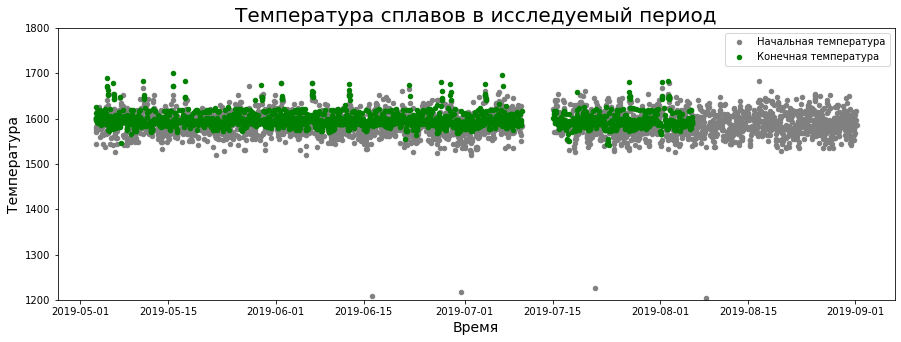

In [17]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(15, 5))

temp.plot('time_temp_last', 'temp_first', kind='scatter', c='gray', label='Начальная температура', ax=ax)
temp.plot('time_temp_last', 'temp_last', kind='scatter', c='green', label='Конечная температура', ax=ax)

plt.ylim(1200, 1800)
ax.set_xlabel('Время', fontsize=14)
ax.set_ylabel('Температура', fontsize=14)
ax.set_title('Температура сплавов в исследуемый период', fontsize=20)

plt.show()

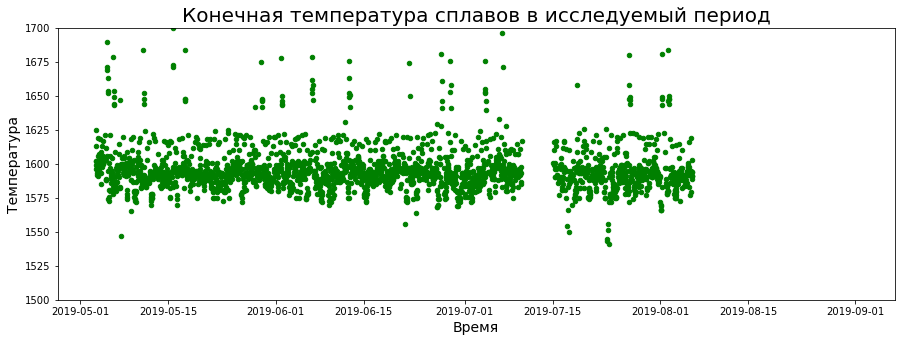

In [18]:
# Create figure 
temp.plot('time_temp_last', 'temp_last', kind='scatter', c='green', figsize=(15, 5))
plt.ylim(1500, 1700)
plt.xlabel('Время', fontsize=14)
plt.ylabel('Температура', fontsize=14)
plt.title('Конечная температура сплавов в исследуемый период', fontsize=20)

plt.show()

Видно, что был небольшой период в середине июля, когда, вероятно, был приостановлен производственный процесс. Видны отсутвующие значения конечной температуры в конце исследуемого периода: начальные температуры регистрировали до сентября, а вот конечные - нет, вероятно, был какой-то технологический сбой в регистрации, так как для других видов данных информация имеется (те отсутвие значений не обусловлено приостановкой процесса производства).

На протяжении всего исследуемого периода конечная температура сплавов варьирует примерно одинаково, можно видеть, что для большей части партий она варьирует около 1590-1600, но видно и другой кластер партий - где финальная температура выше, около 1620, а также некоторые отдельные партии с конечной температурой 1650-1700.

**Пропущенные значения**

Проверим количество и процент пропущенных значений

In [19]:
# number of NaN
print('Количество пропущенных значений в первом замере:')
print((temp.temp_first == -1).sum())
print('Количество пропущенных значений в предпоследнем замере:')
print(((temp.temp_penult == -1) | (temp.temp_penult.isna())).sum())
print('Количество пропущенных значений в последнем замере:')
print((temp.temp_last == -1).sum())
# percentage of NaN (-1)
print('Процент пропущенных значений последней температуры:')
print((temp.temp_last == -1).mean()*100)

Количество пропущенных значений в первом замере:
0
Количество пропущенных значений в предпоследнем замере:
719
Количество пропущенных значений в последнем замере:
739
Процент пропущенных значений последней температуры:
22.978855721393035


Таким образом, для 739 партий отсутвуют записи последней температуры, еще две партии имеют лишь одну запись - мы не можем сказать, первая она или последняя. Примем решение не брать в анализ данные партии, так как мы не можем заполнять значения в целевом признаке.

In [20]:
# drop NaN (-1)
temp = temp.query('key not in @one_mesur and temp_last != -1')
print(f'Количество партий: {len(temp)}')
print(f'Процент удаленных партий: {(n_keys - len(temp)) / n_keys * 100}')

Количество партий: 2475
Процент удаленных партий: 23.041044776119403


Вычислим время между последним и предпоследним замером температуры (в секундах), а также между первым и последним (в минутах). Удилим колонки с датами.

In [21]:
# time between last and second-to-last measure, seconds
temp['time_temp_last_penult'] = (temp.time_temp_last - temp.time_temp_penult).dt.total_seconds()
# time between last and first measure, minutes
temp['time_temp_last_first'] = (temp.time_temp_last - temp.time_temp_first).dt.total_seconds()/60

# drop datetime columns
temp = temp.drop(['time_temp_last', 'time_temp_first', 'time_temp_penult'], axis=1)
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2476
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   key                    2475 non-null   int64  
 1   temp_last              2475 non-null   float64
 2   temp_first             2475 non-null   float64
 3   temp_penult            2475 non-null   float64
 4   time_temp_last_penult  2475 non-null   float64
 5   time_temp_last_first   2475 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 135.4 KB


Посмотрим, как связаны между собой "температурные" признаки и на их распределение и описательную статистику.

In [22]:
# descriptive statistics
temp.drop('key', axis=1).describe()

,temp_last,temp_first,temp_penult,time_temp_last_penult,time_temp_last_first
count,2475.0000,2475.000,2475.0000,2475.0000,2475.0000
mean,1595.3362,1588.402,1592.7838,276.4691,30.9159
std,16.0232,29.243,16.4853,196.9422,21.6874
min,1541.0000,1191.000,1537.0000,13.0000,3.9000
25%,1587.0000,1572.000,1584.0000,141.0000,19.7083
50%,1593.0000,1588.000,1591.0000,242.0000,26.5500
75%,1599.0000,1605.000,1598.0000,364.0000,37.7083
max,1700.0000,1679.000,1705.0000,2347.0000,392.2833


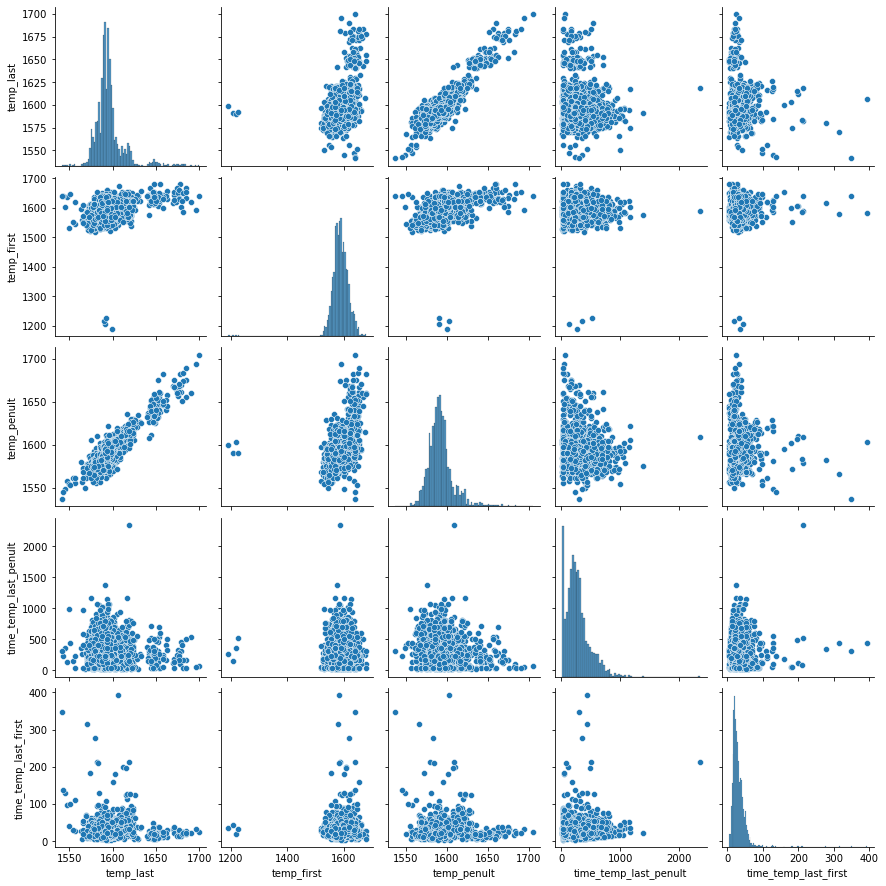

In [23]:
# scatterplots and distribution histograms
sns.pairplot(temp.drop('key', axis=1))

Видна практически линейная зависимость финальной температуры сплава от предпоследней измеренной температуры, есть некоторая зависимость и от изначальной температуры - чем выше эти показатели, тем выше и финальная температура. Наблюдаются как бы три кластера финальных температур - самый большой около 1600, и два маленьких - около 1650 и 1675, что может говорить о наличии возможно трех очновных типов сплавов. 

Рассмотрим подробнее зависимость конечной температуры сплава от предпоследней, учитывая время между измерениями.

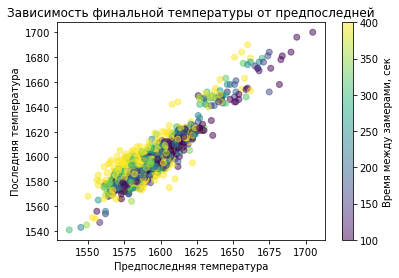

In [24]:
# scatterplot: last temperature(second-to-lasttemperature)
plt.scatter(temp['temp_penult'], 
            temp['temp_last'],
            c=temp['time_temp_last_penult'],
            alpha = .5, cmap = 'viridis',
            vmin=100, vmax=400
           )

plt.colorbar(label='Время между замерами, сек')
plt.title('Зависимость финальной температуры от предпоследней')
plt.xlabel('Предпоследняя температура')
plt.ylabel('Последняя температура')
plt.show()

Заметно, что чем меньше время между последним и предпоследним измерениями, тем выше была предпоследняя температура при схожих конечных, что кажется логичным.

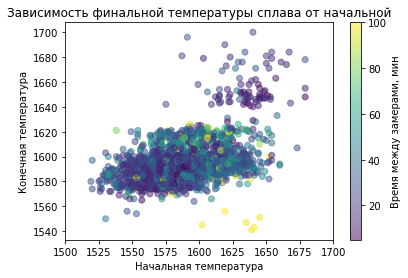

In [25]:
# scatterplot: last temperature(first temperature)
plt.scatter(temp['temp_first'], 
            temp['temp_last'],
            c=temp['time_temp_last_first'],
            alpha = .5, cmap = 'viridis',
            vmin=5, vmax=100
           )

plt.colorbar(label='Время между замерами, мин')
plt.title('Зависимость финальной температуры сплава от начальной')
plt.xlabel('Начальная температура')
plt.ylabel('Конечная температура')
plt.xlim(1500, 1700)
plt.show()

Видно, что для более высоких начальных температур сплавов при длительности обработки менее 20 минут, как правило конечная температура также более высокая, а при более длительном процессе - она ниже. 

Поскольку промежуточные данные замеров температуры получают в ходе процесса обработки, в рамках данной задачи они как бы недоступны (остальные параметры могут быть заданы ДО начала процесса), исключим эти показатели для дальнейшего анализа.

In [26]:
temp = temp.drop(['temp_penult', 'time_temp_last_penult'], axis=1)
temp

,key,temp_last,temp_first,time_temp_last_first
0,1,1613.0,1571.0,14.3500
1,2,1602.0,1581.0,21.7500
2,3,1599.0,1596.0,21.6667
3,4,1625.0,1601.0,6.4667
4,5,1602.0,1576.0,12.7000
...,...,...,...,...
2472,2495,1591.0,1570.0,18.9500
2473,2496,1591.0,1554.0,26.9667
2474,2497,1589.0,1571.0,11.9500
2475,2498,1594.0,1591.0,21.7000


**Вывод:** Был выделен целевой признак - последний замер температуры для каждой партии стали. В этом признаке оказалось около 20% пропущенных значений, так как мы не можем заполнять значения целевого признака - было принято решение удалить партии, где нет конечного замера температуры.<br>
Были добавлены признаки: 
- начальная температура
- время между последним и первым замером температуры

Конечная температура варьирует примерно одинаково в течение исследуемого периода, от 1541 до 1700, и в среднем составляет около 1600. Видно, что есть как бы три основных кластера - около 1600 (самый обширный), 1650 и 1675, что может соответствовать трем основным производимым типам стали. 

Начальная температура изменяется в более широких пределах - для единичных случаев нижняя граница может быть около 1200. Кажется, что длительность процесса обработки может быть связана с конечной температурой - для сплавов с более высокой начальной температурой конечная температура как правило более высокая при менее длительной обработке.<br>

Длительность же обработки, вычесленная как разница во времени в минутах между последним и первым замером температуры, для большинства партий не превышает 40 минут, но может и более 3 часов (вплоть до 6.5), что кажется странным.

Предпоследняя температура практически повторяет значения последней, видна четкая линейная зависимость, однако брать этот показатель в исследование мы не можем.

#### Нагрев электродов

Данные параметры являются важными, так как снизив длятельность/количество нагревов можно существенно снизить потребление энергии, это самый энергозатратный процесс.

In [27]:
print('Количество партий', data['arc'].key.nunique())

Количество партий 3214


Имеются данные для 3214 партий, добавим их в датафрейм `arc`.

In [28]:
# create dataframe
arc = data['arc'].copy().rename(columns={'Начало нагрева дугой': 'start_heat', 
                                         'Конец нагрева дугой': 'end_heat', 
                                         'Активная мощность': 'power_act', 
                                         'Реактивная мощность': 'power_react'})

# change column type to datetime
arc[['start_heat', 'end_heat']] = arc[['start_heat', 'end_heat']].apply(pd.to_datetime)

arc.describe(datetime_is_numeric=True)

,key,start_heat,end_heat,power_act,power_react
count,14876.0000,14876,14876,14876.0000,14876.0000
mean,1615.2204,2019-07-02 16:15:28.218203904,2019-07-02 16:18:19.889150208,0.6704,0.4526
min,1.0000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.0300,-715.5049
25%,806.0000,2019-06-02 07:01:09.249999872,2019-06-02 07:04:21,0.3953,0.2910
50%,1617.0000,2019-06-30 09:57:14.500000,2019-06-30 10:01:01,0.5555,0.4160
75%,2429.0000,2019-08-03 13:04:47.750000128,2019-08-03 13:09:14,0.8570,0.6374
max,3241.0000,2019-09-01 04:34:47,2019-09-01 04:36:08,3.7316,2.6764
std,934.5715,NaN,NaN,0.4082,5.8787


Есть аномальное значение реактивной мощности -715, посмотрим, много ли таких значений.

In [29]:
# data with reactive power < 0 
arc.query('power_react < 0')

,key,start_heat,end_heat,power_act,power_react
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.4958,-715.5049


Такое значение всего одно, примем решение заменить его на 0. Если бы таких значений было много - можно было бы заполнить их на основе соседних значений и только в обучающей выборке. 

In [30]:
# replace reactive power < 0 with 0
arc.loc[arc['power_react'] < 0, 'power_react'] = 0
# data with reactive power < 0  
print('Количество данных с отрицательной реактивной мощностью:', len(arc.query('power_react < 0')))

Количество данных с отрицательной реактивной мощностью: 0


**Создание признаков**

Для каждого цикла нагрева рассчитаем его длительность в минутах. 

In [31]:
# calculate heat duration for each cycle
arc['heat_duration_min'] = (arc.end_heat - arc.start_heat).dt.total_seconds()/60
arc.head()

,key,start_heat,end_heat,power_act,power_react,heat_duration_min
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.9761,0.6871,3.8000
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.8056,0.5203,3.0833
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.7444,0.4988,2.8667
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.6594,1.0627,6.0833
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.6928,0.4144,2.4667


Реактивная составляющая мощности не равна нулю, учтем это рассчитав полную мощность и коэффициент мощности, отражающий наличие и долю реактивной составляющей мощности (при ее отсутвии равен 1), равный отношению активной мощности к полной мощности, которая, в свою очередь, равна: $P = \sqrt(Pa^2 + Pr^2)$, где $Pa$ - активная мощность, а $Pr$ - реактивная мощность.

In [32]:
# calculate complex power and power factor
arc['power'] = np.sqrt(arc['power_act']**2 + arc['power_react']**2)
arc['power_factor'] = arc['power_act'] / arc['power']
arc.head(3)

,key,start_heat,end_heat,power_act,power_react,heat_duration_min,power,power_factor
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.9761,0.6871,3.8000,1.1936,0.8177
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.8056,0.5203,3.0833,0.9590,0.8400
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.7444,0.4988,2.8667,0.8960,0.8307


Сгруппируем данные по партиям и создадим аггрегированные признаки для каждой группы: 
- суммарную активную мощность
- активную мощность последнего цикла нагрева
- медианное значение фактора мощности
- количество циклов нагрева
- суммарное время нагрева 
- время начала первого нагрева и окончания последнего.

In [33]:
# create dataframe with data grouped by key
arc_sum = arc.groupby('key', as_index=False).agg(
    power_sum=('power_act', 'sum'),
    power_last=('power_act', 'last'),
    power_factor=('power_factor', 'median'),
    n_heats=('key', 'size'),
    duration_heat_sum=('heat_duration_min', 'sum'),
    start=('start_heat', 'min'),
    end=('end_heat', 'max'))

Рассчитаем для каждой партии суммарную длительность периодов, когда нагрев не происходил, в минутах. Удалим избыточные переменные. Удалим также суммарную длительность нагрева, так как ее смысл дублируется суммарной мощностью.

In [34]:
# add heat duration and rest duration, in minutes
arc_sum['duration_all'] = (arc_sum.end - arc_sum.start).dt.total_seconds()/60
arc_sum['duration_rest_sum'] = arc_sum['duration_all'] - arc_sum['duration_heat_sum']

# drop some variables
arc_sum.drop(['start', 'end', 'duration_all', 'duration_heat_sum'], axis=1, inplace=True)
arc_sum

,key,power_sum,power_last,power_factor,n_heats,duration_rest_sum
0,1,4.8781,0.6928,0.8400,5,8.0833
1,2,3.0526,0.8277,0.8441,4,5.5500
2,3,2.5259,0.2503,0.8452,5,14.5000
3,4,3.2093,1.2210,0.8482,4,5.8667
4,5,3.3472,0.2675,0.8318,4,8.2167
...,...,...,...,...,...,...
3209,3237,3.9325,0.6060,0.8162,5,7.3500
3210,3238,2.1065,0.7176,0.7680,3,6.0667
3211,3239,4.6668,0.4884,0.8371,8,28.5667
3212,3240,2.9841,0.5489,0.7963,5,44.7500


Посмотрим, как связаны признаки между собой, их распределение и описательную статистику.

In [35]:
# descriptive statistics
arc_sum.drop('key', axis=1).describe()

,power_sum,power_last,power_factor,n_heats,duration_rest_sum
count,3214.0000,3214.0000,3214.0000,3214.0000,3214.0000
mean,3.1031,0.4902,0.8044,4.6285,18.3993
std,1.3974,0.2870,0.0345,1.6086,18.1401
min,0.1862,0.0300,0.5091,1.0000,0.0000
25%,2.1263,0.2874,0.7919,4.0000,8.8000
50%,2.9905,0.4207,0.8106,4.0000,14.2417
75%,3.9011,0.6109,0.8252,6.0000,23.7625
max,17.4965,2.9095,0.8843,16.0000,321.6000


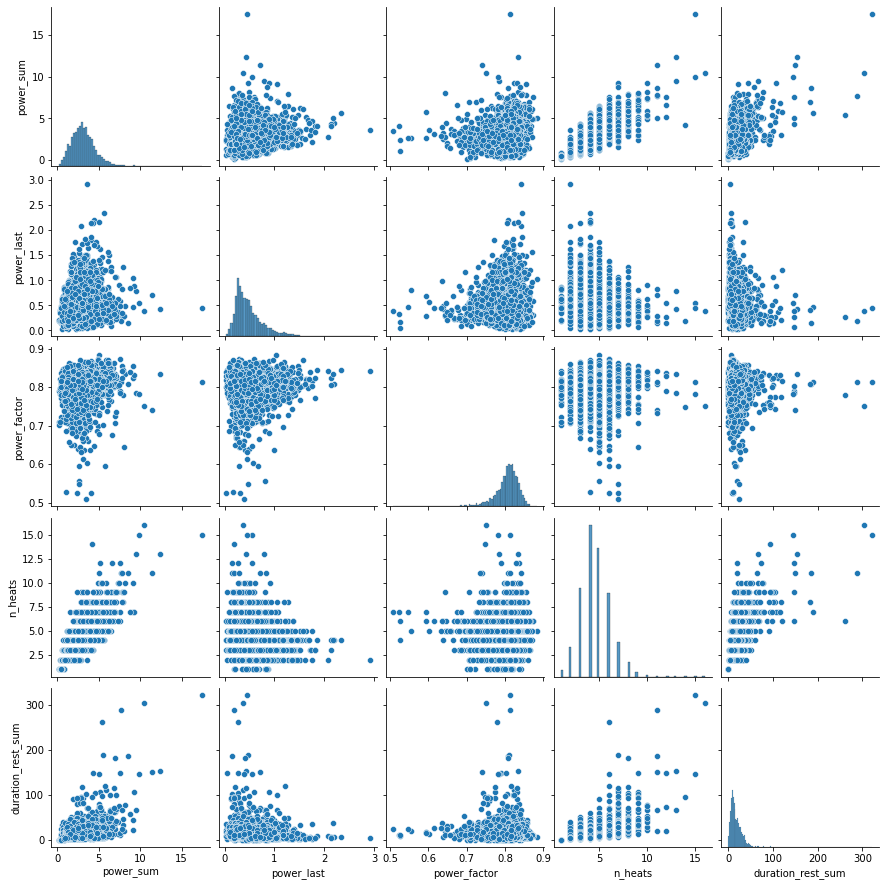

In [36]:
# scatterplots and distribution histograms
sns.pairplot(arc_sum.drop('key', axis=1))

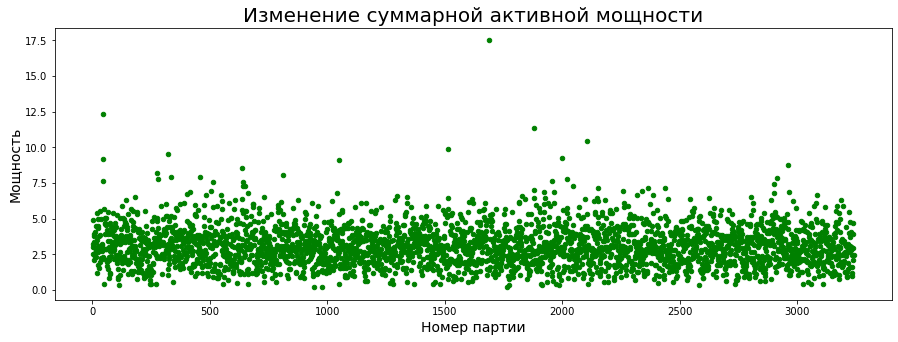

In [37]:
# Create figure 
arc_sum.plot('key', 'power_sum', kind='scatter', c='green', figsize=(15, 5))

plt.xlabel('Номер партии', fontsize=14)
plt.ylabel('Мощность', fontsize=14)
plt.title('Изменение суммарной активной мощности', fontsize=20)

plt.show()

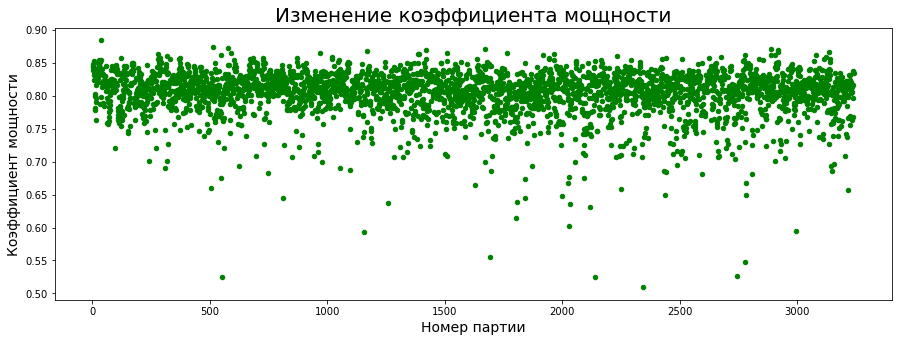

In [38]:
# Create figure 
arc_sum.plot('key', 'power_factor', kind='scatter', c='green', figsize=(15, 5))

plt.xlabel('Номер партии', fontsize=14)
plt.ylabel('Коэффициент мощности', fontsize=14)
plt.title('Изменение коэффициента мощности', fontsize=20)

plt.show()

**Вывод:** Была обнаружена одна запись с аномальной реактивной мощностью (-715), так как такая запись была одна было принято решение заменить это значение реактивной мощности на 0. 

На основе данных были созданы следующие признаки для каждой партии:
- суммарная активная мощность
- значение активной мощности в последнем цикле нагрева
- медианное значение коэффициента мощности
- количество циклов нагрева
- суммарная длительность бездействия в минутах

Суммарная активная мощность меняется примерно одинаково в зависимости от партий, хотя есть отдельные единичные выбросы, превышающие среднее (около 3) в 3-6 раз.
В большинстве партий коэффициент мощности не меньше 0.79, но есть периодически партии со значением менее 0.7 (минимум 0.5), что может говорить о высокой реактивной мощности, на комбинате могут провести анализ, с чем может быть связаны высокая реактивная мощность при нагреве сплава.<br>
Среднее суммарное время бездействия (когда нагрев не работает) составляет около 9 минут, но есть партии, где этот показатель больше 300 мин или равен 0. А количество циклов нагрева, обычно около 4, в некоторых партиях достигает 16.Исходя из этих показателей, создается впечатление, что процесс нагрева стали может быть оптимизирован (количество циклов, их длительность).

Низкий коэффициент мощности характерен для сплавов с низкой суммарной потраченной на нагрев мощностью, однако для самызх высоких его значений суммарная мощность может варьировать во всем регистрируемом диапазоне. Время бездействия тем больше, чем больше суммарная активная мощность, что логично (вероятно длиннее весь процесс, так как и количество циклов при этом обычно больше).

#### Легирующие добавки

Заказчик не предоставил информации о производимых марках стали. Номера сыпучих и "проволочных" легирующих добавок вероятно соответсвуют разным химическим веществам. 

In [39]:
print('Количество партий с сыпучими добавками:', len(data['bulk']))
print('Количество партий с "проволочными" добавками:', len(data['wire']))

# shared keys
keys_bw = data['wire']['key'][data['wire']['key'].isin(data['bulk']['key'])].tolist()
print('Количество партий с двумя типами добавок:', len(keys_bw))

Количество партий с сыпучими добавками: 3129
Количество партий с "проволочными" добавками: 3081
Количество партий с двумя типами добавок: 3025


Видно, что не во всех партиях было оба типа добавок - где-то присутсвовали только сыпучие, а где-то только "проволочные". Нам известно, что для анализа нужны только те партии, где присутсвуют оба типа добавок, в дальнейшем ограничимся только ими.

- Сыпучие легирующие добавки

In [40]:
# descriptive statistics for bulk alloying additions
data['bulk'].drop('key', axis=1).describe()

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,252.0000,22.0000,1298.0000,1014.0000,77.0000,576.0000,25.0000,1.0,19.0000,176.0000,177.0000,2450.0000,18.0000,2806.0000,2248.0000
mean,39.2421,253.0455,113.8790,104.3945,107.0260,118.9253,305.6000,49.0,76.3158,83.2841,76.8192,260.4710,181.1111,170.2847,160.5133
std,18.2777,21.1806,75.4835,48.1841,81.7906,72.0578,191.0229,NaN,21.7206,26.0603,59.6554,120.6493,46.0880,65.8687,51.7653
min,10.0000,228.0000,6.0000,12.0000,11.0000,17.0000,47.0000,49.0,63.0000,24.0000,8.0000,53.0000,151.0000,16.0000,1.0000
25%,27.0000,242.0000,58.0000,72.0000,70.0000,69.7500,155.0000,49.0,66.0000,64.0000,25.0000,204.0000,153.2500,119.0000,105.0000
50%,31.0000,251.5000,97.5000,102.0000,86.0000,100.0000,298.0000,49.0,68.0000,86.5000,64.0000,208.0000,155.5000,151.0000,160.0000
75%,46.0000,257.7500,152.0000,133.0000,132.0000,157.0000,406.0000,49.0,70.5000,102.0000,106.0000,316.0000,203.5000,205.7500,205.0000
max,185.0000,325.0000,454.0000,281.0000,603.0000,503.0000,772.0000,49.0,147.0000,159.0000,313.0000,1849.0000,305.0000,636.0000,405.0000


Объемы разных добавок меняются в похожих пределах, за исключением 'Bulk 12', максимальный объем которой сильно выделяется, и 'Bulk 15', у которой минимальный объем всего 1.

Переведем данные из "широкого" в "длинный формат".

In [41]:
# change dataframe format from "wide" to "long"
# drop Nan
bulk_long = pd.melt(data['bulk'], id_vars="key", var_name='addition', value_name='add_volume').dropna()
bulk_long

,key,addition,add_volume
11,12,Bulk 1,46.0
48,57,Bulk 1,27.0
49,58,Bulk 1,48.0
50,59,Bulk 1,29.0
51,60,Bulk 1,46.0
...,...,...,...
46930,3237,Bulk 15,206.0
46931,3238,Bulk 15,106.0
46932,3239,Bulk 15,88.0
46933,3240,Bulk 15,54.0


Проверим, совпадает ли суммарный объем в исходных данных и новом датафрейме.

In [42]:
# check the equality of total volumes
data['bulk']['Bulk 1'].sum() == bulk_long.query('addition == "Bulk 1"')['add_volume'].sum()

True

Переведем в "длинный формат также данные со временем введения сыпучих легирующих добавок.

In [43]:
# change dataframe format from "wide" to "long"
# drop Nan
bulk_time_long = pd.melt(data['bulk_time'], id_vars="key", var_name='addition', value_name='date_time').dropna()
bulk_time_long

,key,addition,date_time
11,12,Bulk 1,2019-05-03 17:50:19
48,57,Bulk 1,2019-05-05 10:09:13
49,58,Bulk 1,2019-05-05 11:01:42
50,59,Bulk 1,2019-05-05 11:59:23
51,60,Bulk 1,2019-05-05 13:13:45
...,...,...,...
46930,3237,Bulk 15,2019-08-31 22:46:52
46931,3238,Bulk 15,2019-08-31 23:33:09
46932,3239,Bulk 15,2019-09-01 01:33:25
46933,3240,Bulk 15,2019-09-01 02:41:27


Добавим информацию о времени введения добавок в датафрейм с объемами.

In [44]:
# add datetime information
bulk_long['date_time'] = bulk_time_long['date_time']
bulk_long.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11159 entries, 11 to 46934
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         11159 non-null  int64  
 1   addition    11159 non-null  object 
 2   add_volume  11159 non-null  float64
 3   date_time   11159 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 435.9+ KB


Помня об увиденных выбросах в значениях объема некоторых добавок, исследуем их.

In [45]:
# lots with bulk addition volume > 1000 or < 5
bulk_long.query('add_volume<5 or add_volume>1000')

,key,addition,add_volume,date_time
34722,322,Bulk 12,1849.0,2019-05-15 09:22:19
44335,558,Bulk 15,1.0,2019-05-24 02:38:45


In [46]:
# lots with outliers
bulk_long.query('key in [322, 558]').sort_values(by='date_time')

,key,addition,add_volume,date_time
34722,322,Bulk 12,1849.0,2019-05-15 09:22:19
40980,322,Bulk 14,636.0,2019-05-15 09:22:19
303,322,Bulk 1,185.0,2019-05-15 09:27:40
6561,322,Bulk 3,101.0,2019-05-15 09:35:53
19077,322,Bulk 7,406.0,2019-05-15 09:35:53
9690,322,Bulk 4,58.0,2019-05-15 09:58:38
41206,558,Bulk 14,108.0,2019-05-24 02:38:45
44335,558,Bulk 15,1.0,2019-05-24 02:38:45
28690,558,Bulk 10,100.0,2019-05-24 02:45:20


Поскольку мы не знаем единиц измерения и в каких пределах могут варьировать объемы добавок, оставим эти "выбросы" как есть.

- "Проволочные" легирующие добавки.

In [47]:
# descriptive statistics for wire alloying additions
data['wire'].drop('key', axis=1).describe()

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3055.0000,1079.0000,63.0000,14.0000,1.000,73.0000,11.0000,19.0000,29.0000
mean,100.8959,50.5773,189.4827,57.4428,15.132,48.0170,10.0390,53.6252,34.1558
std,42.0125,39.3202,99.5134,28.8247,NaN,33.9198,8.6106,16.8817,19.9316
min,1.9188,0.0302,0.1441,24.1488,15.132,0.0343,0.2342,45.0767,4.6228
25%,72.1157,20.1937,95.1350,40.8070,15.132,25.0536,6.7628,46.0949,22.0584
50%,100.1582,40.1430,235.1950,45.2343,15.132,42.0763,9.0170,46.2800,30.0664
75%,126.0605,70.2276,276.2520,76.1246,15.132,64.2127,11.8861,48.0896,43.8620
max,330.3144,282.7802,385.0087,113.2310,15.132,180.4546,32.8477,102.7624,90.0536


Объемы разных добавок меняются в похожих пределах. В целом, объемы "проволочных" добавок значительно меньше, по сравнению с сыпучими.

Переведем данные из "широкого" в "длинный формат".

In [48]:
# change dataframe format from "wide" to "long"
# drop Nan
wire_long = pd.melt(data['wire'], id_vars="key", var_name='addition', value_name='add_volume').dropna()
wire_long

,key,addition,add_volume
0,1,Wire 1,60.0600
1,2,Wire 1,96.0523
2,3,Wire 1,91.1602
3,4,Wire 1,89.0635
4,5,Wire 1,89.2382
...,...,...,...
26991,2468,Wire 9,63.0448
26992,2470,Wire 9,11.3568
26993,2471,Wire 9,63.0448
26994,2472,Wire 9,39.9672


Проверим, совпадает ли суммарный объем "Wire 7" в исходных данных и новом датафрейме.

In [49]:
# check 
data['wire']['Wire 7'].sum() == wire_long.query('addition == "Wire 7"')['add_volume'].sum()

True

Также переведем в длинный формат данные времени введения добавок.

In [50]:
# change dataframe format from "wide" to "long"
# drop Nan
wire_time_long = pd.melt(data['wire_time'], id_vars="key", var_name='addition', value_name='date_time').dropna()
wire_time_long

,key,addition,date_time
0,1,Wire 1,2019-05-03 11:11:41
1,2,Wire 1,2019-05-03 11:46:10
2,3,Wire 1,2019-05-03 12:13:47
3,4,Wire 1,2019-05-03 12:48:05
4,5,Wire 1,2019-05-03 13:18:15
...,...,...,...
26991,2468,Wire 9,2019-08-05 00:21:11
26992,2470,Wire 9,2019-08-05 01:13:57
26993,2471,Wire 9,2019-08-05 02:48:39
26994,2472,Wire 9,2019-08-05 04:16:10


Добавим данные о времени в датасет с объемами "проволочных" добавок.

In [51]:
# add datetime information
wire_long['date_time'] = wire_time_long['date_time']
wire_long.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4344 entries, 0 to 27641
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         4344 non-null   int64  
 1   addition    4344 non-null   object 
 2   add_volume  4344 non-null   float64
 3   date_time   4344 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 169.7+ KB


Объединим датафреймы с информацией о двух разных видах легирующих добавок и оставим только те партии, где были использованы оба типа добавок.

In [52]:
# concatenate "Bulk" and "Wire"
add = bulk_long.append(wire_long)

# keys only in "shared keys"
add = add.query('key in @keys_bw')

In [53]:
# check number of keys
add['key'].nunique() == len(keys_bw)

True

Cоздадим столбец-"флаг" типа легирующей добавки.

In [54]:
# add class of additions
add['add_class'] = add['addition'].str.extract(r'^(\S+)', expand=False).str.lower()

# change data to datetime type
add['date_time'] = pd.to_datetime(add['date_time'])
add.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15206 entries, 11 to 27641
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   key         15206 non-null  int64         
 1   addition    15206 non-null  object        
 2   add_volume  15206 non-null  float64       
 3   date_time   15206 non-null  datetime64[ns]
 4   add_class   15206 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 712.8+ KB


От состава легирующих добавок зависит марка стали, посмотрим, какие сочетания легирующих добавок имеются и сколько их.

In [55]:
# different combinations of alloying additions
steel_grades = add.groupby('key')['addition'].unique().reset_index()
steel_grades['addition'] = steel_grades['addition'].apply(tuple)
steel_grades

,key,addition
0,1,"(Bulk 4, Bulk 12, Bulk 14, Bulk 15, Wire 1)"
1,2,"(Bulk 4, Bulk 12, Bulk 14, Bulk 15, Wire 1)"
2,3,"(Bulk 4, Bulk 12, Bulk 14, Bulk 15, Wire 1)"
3,4,"(Bulk 4, Bulk 12, Bulk 14, Bulk 15, Wire 1)"
4,5,"(Bulk 4, Bulk 12, Bulk 14, Bulk 15, Wire 1, Wire 2)"
...,...,...
3020,3237,"(Bulk 3, Bulk 12, Bulk 14, Bulk 15, Wire 1)"
3021,3238,"(Bulk 3, Bulk 12, Bulk 14, Bulk 15, Wire 1)"
3022,3239,"(Bulk 6, Bulk 12, Bulk 14, Bulk 15, Wire 1)"
3023,3240,"(Bulk 6, Bulk 14, Bulk 15, Wire 1)"


In [56]:
# number of each "steel grade"
steel_grades['addition'].value_counts()

(Bulk 4, Bulk 12, Bulk 14, Bulk 15, Wire 1)                            427
(Bulk 3, Bulk 12, Bulk 14, Bulk 15, Wire 1)                            345
(Bulk 3, Bulk 12, Bulk 14, Bulk 15, Wire 1, Wire 2)                    194
(Bulk 12, Bulk 14, Bulk 15, Wire 1)                                    155
(Bulk 12, Bulk 14, Bulk 15, Wire 1, Wire 2)                            116
                                                                      ... 
(Bulk 10, Wire 1, Wire 2)                                                1
(Bulk 1, Bulk 4, Bulk 10, Bulk 12, Bulk 14, Bulk 15, Wire 1)             1
(Bulk 11, Bulk 14, Wire 1, Wire 2)                                       1
(Bulk 6, Bulk 14, Wire 6)                                                1
(Bulk 1, Bulk 5, Bulk 6, Bulk 12, Bulk 14, Bulk 15, Wire 1, Wire 2)      1
Name: addition, Length: 270, dtype: int64

В имеющихся данных всего 270 разных сочетания легирующих добавок, можно предположить, что это разные марки стали, ведь всего марок стали [более 700](https://ru.wikipedia.org/wiki/%D0%9C%D0%B0%D1%80%D0%BA%D0%B8_%D1%81%D1%82%D0%B0%D0%BB%D0%B8).

Много партий производят одну и ту же марку стали, но есть и уникальные.

Добавим каждой "марке" стали уникальный идентификатор.

In [57]:
# add id to each steel grade
steel_grades['grade_id'] = steel_grades.groupby('addition').ngroup() + 1
steel_grades.sort_values(by="grade_id")

,key,addition,grade_id
1999,2131,"(Bulk 1, Bulk 10, Bulk 12, Bulk 14, Bulk 15, Wire 1)",1
1375,1470,"(Bulk 1, Bulk 10, Bulk 12, Bulk 14, Bulk 15, Wire 1)",1
1603,1711,"(Bulk 1, Bulk 10, Bulk 12, Bulk 14, Bulk 15, Wire 1, Wire 2)",2
811,877,"(Bulk 1, Bulk 10, Bulk 12, Bulk 14, Wire 1)",3
1611,1719,"(Bulk 1, Bulk 10, Bulk 12, Bulk 14, Wire 1)",3
...,...,...,...
2996,3212,"(Bulk 7, Wire 1)",268
1827,1948,"(Bulk 7, Wire 1, Wire 4)",269
1825,1945,"(Bulk 7, Wire 1, Wire 4)",269
252,281,"(Bulk 9, Bulk 12, Bulk 14, Wire 1, Wire 2, Wire 8)",270


Создадим сгруппированный по партиям датафрейм, добавив аггрегированные признаки для каждой партии: суммарный объем добавок, количество добавок, объем последней добавки. 

Теоретически, суммарный объем добавок может влиять на затрачиваемую мощность на нагрев сплава, так как он увеличивает суммарный объем для нагрева, а значит и мощность необходима больше. Объем последней добавки может непосредственно влиять на конечную температуру.

In [58]:
# create dataframe grouped by key 
add_gr = add.sort_values(by='date_time').groupby('key', as_index=False)

# create aggregated features
additions = add_gr.agg(volume_sum=('add_volume', 'sum'), 
                       volume_last = ('add_volume', 'last'),
                       n_additions=('key', 'size'))
additions

,key,volume_sum,volume_last,n_additions
0,1,613.0600,43.0000,5
1,2,678.0523,73.0000,5
2,3,635.1602,34.0000,5
3,4,684.0635,81.0000,5
4,5,682.3528,9.1146,6
...,...,...,...,...
3020,3237,796.0890,170.0000,5
3021,3238,650.1288,126.0000,5
3022,3239,773.3578,114.0000,5
3023,3240,306.0704,26.0000,4


Разный тип легирующих добавок может по-разному влиять на температуру сплава, поэтому введем еще некоторые параметры: количество "проволочных" добавок, суммарный их объем, а также добавим "марку" стали.

In [59]:
# add more aggregated features
additions['volume_wire_sum'] = add_gr.apply(lambda x: x[x['add_class'] == 'wire']['add_volume'].sum()).iloc[:,1]
additions['n_wires'] = add_gr.apply(lambda x: x[x['add_class'] == 'wire']['add_volume'].count()).iloc[:,1]
additions['grade_id'] = steel_grades['grade_id']
additions

,key,volume_sum,volume_last,n_additions,volume_wire_sum,n_wires,grade_id
0,1,613.0600,43.0000,5,60.0600,1,202
1,2,678.0523,73.0000,5,96.0523,1,202
2,3,635.1602,34.0000,5,91.1602,1,202
3,4,684.0635,81.0000,5,89.0635,1,202
4,5,682.3528,9.1146,6,98.3528,2,203
...,...,...,...,...,...,...,...
3020,3237,796.0890,170.0000,5,38.0890,1,116
3021,3238,650.1288,126.0000,5,56.1288,1,116
3022,3239,773.3578,114.0000,5,143.3578,1,250
3023,3240,306.0704,26.0000,4,34.0704,1,257


Проверим получившийся датафрейм.

In [60]:
# check total volume of wire additions
data['wire'].query('key in @keys_bw').iloc[:, 1:].sum().sum() - additions['volume_wire_sum'].sum() < 0.0001

True

In [61]:
# check total number of wire additions
data['wire'].query('key in @keys_bw').iloc[:, 1:].count().sum() == additions['n_wires'].sum()

True

In [62]:
# check total volume of Wire 7
keys = list(data['wire'].query('key in @keys_bw')[~data['wire']['Wire 7'].isna()]['key'])

(data['wire']
 .query('key in @keys').iloc[:, 1:]
 .sum().sum() == additions.query('key in @keys')['volume_wire_sum'].sum())

True

Посмотрим на описательную статистику и распределение данных.

In [63]:
# descriptive statistics
additions.drop(['key', 'grade_id'], axis=1).describe()

,volume_sum,volume_last,n_additions,volume_wire_sum,n_wires
count,3025.0000,3025.0000,3025.0000,3025.0000,3025.0000
mean,726.1957,88.8828,5.0268,123.8331,1.4073
std,285.0360,65.4638,1.2831,65.8497,0.5768
min,54.0622,0.0343,2.0000,1.9188,1.0000
25%,557.9950,41.0000,4.0000,86.4864,1.0000
50%,722.2317,76.0000,5.0000,114.1920,1.0000
75%,916.6850,116.0000,6.0000,150.1812,2.0000
max,3423.2285,512.0000,10.0000,663.8518,5.0000


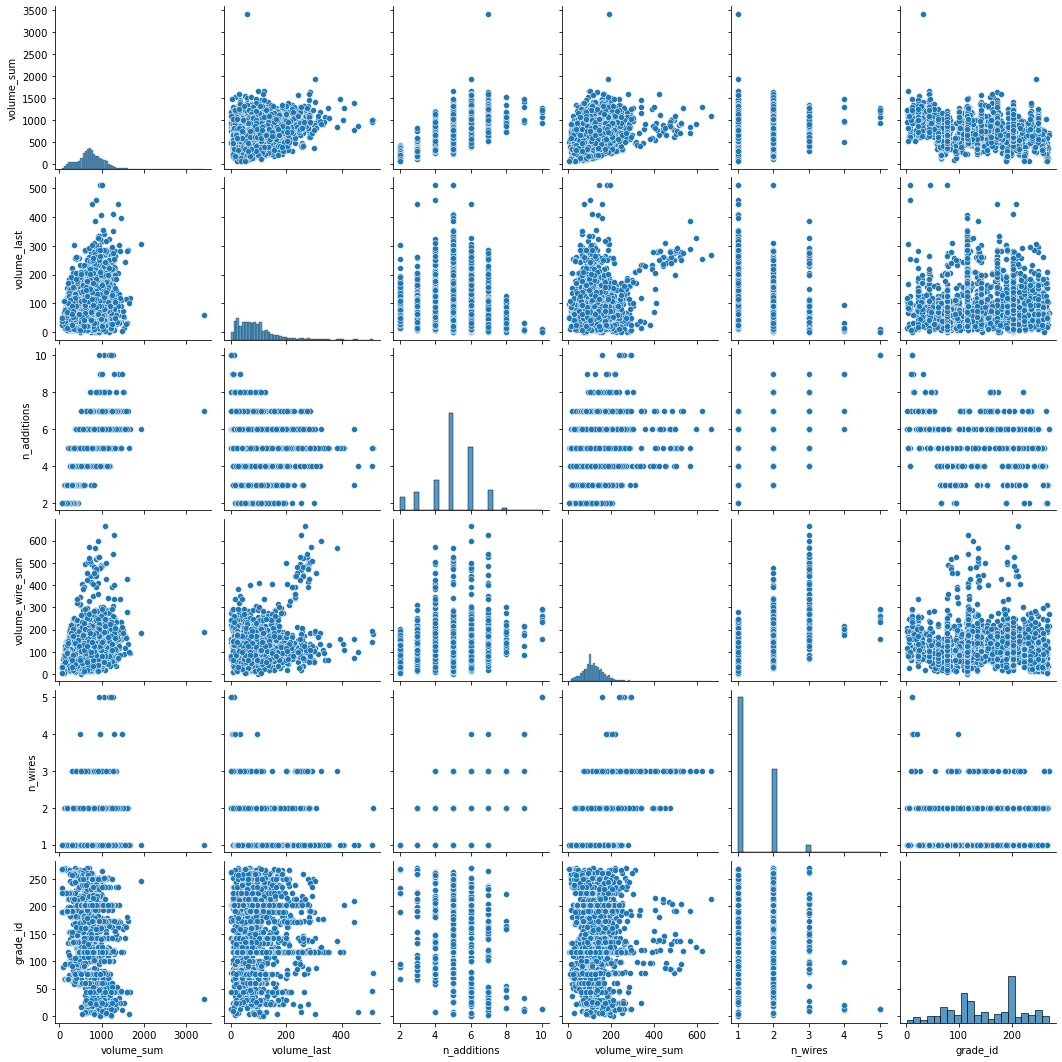

In [64]:
# scatterplots and distribution histograms
sns.pairplot(additions.drop('key', axis=1))

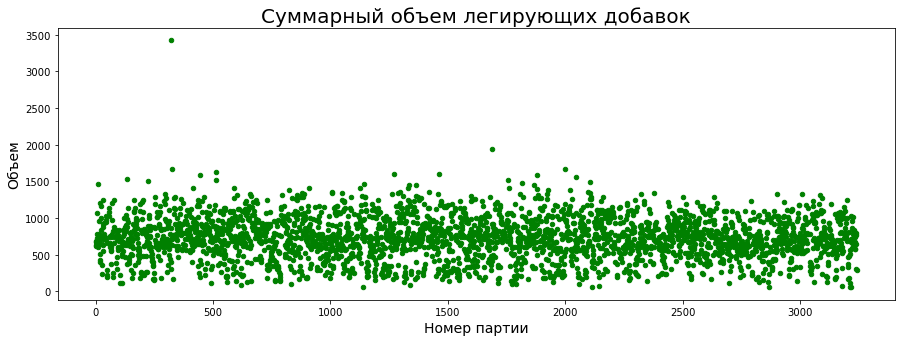

In [65]:
# Create figure 
additions.plot('key', 'volume_sum', kind='scatter', c='green', figsize=(15, 5))

plt.xlabel('Номер партии', fontsize=14)
plt.ylabel('Объем', fontsize=14)
plt.title('Суммарный объем легирующих добавок', fontsize=20)

plt.show()

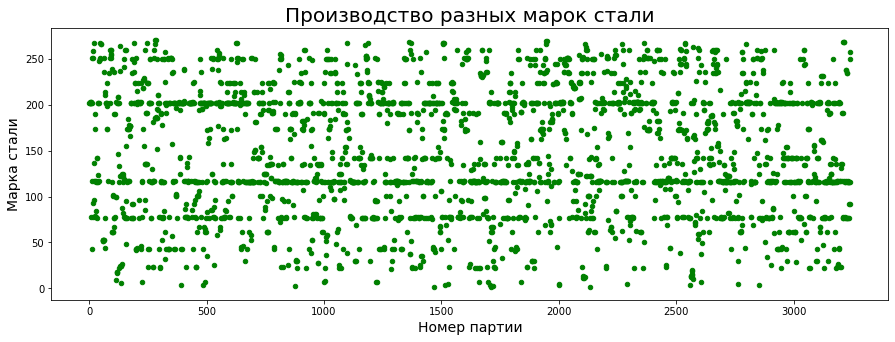

In [66]:
# Create figure 
additions.plot('key', 'grade_id', kind='scatter', c='green', figsize=(15, 5))

plt.xlabel('Номер партии', fontsize=14)
plt.ylabel('Марка стали', fontsize=14)
plt.title('Производство разных марок стали', fontsize=20)

plt.show()

**Вывод:** На основе данных были созданы следующие признаки для каждой партии:
- суммарный объем легирующих добавок
- объем последней добавки
- количество введений легирующих добавок
- суммарный объем легирующих добавок в виде проволоки
- количество легирующих добавок в виде проволоки
- "марка" стали, отражающая разные сочетания легирующих добавок.

Общий объем добавок может влиять на финальную температуру и, если он не очень мал по сравнению с общим объемом котла (единицы измерения нам не известны), может влиять и на мощность, которую необходимо затратить на нагрев сплава. Общий суммарный объем легирующих добавок в среднем составляет около 700, но разброс его велик, от 54 до более 3000. Кажется, что последней добавкой чаще бывает "проволочная". Объем таких добавок в целом меньше сыпучих. Суммарный объем "проволочных" добавок в среднем составляет около 90, но есть партии и с объемом окло 2 и до более 500, количество же их как правило равно одной, в больинстве партий - меньше 2.

Было обнаружено, что в данных имеется 270 разных марок стали, однако видно, что производят как правило 3 основные, что согласуется и с предположением о 3 основных типах стали согласно "кластерами" финальной температуры. С двумя добавками производят не очень много марок, как и с 8 и более, в основном стали содержат 4-6 легирующих добавок.

**Общий вывод по исследованию данных и созданию признаков**: 

Были загружены и проанализированы 7 датасетов с данными об измерении температуры сплавов, мощности при их нагреве и объемах и времени введения легирующих добавок. В целевом признаке - финальной температуре сплава было обнаружено около 20% пропущенных значений, партии без финальной температуры было решено удалить. В итоге имеются данные о процессе обработки 2475 партий (80%) стали. Из разных датасетов были получены параметры:

Из данных о температуре сплавов:
- последний замер температуры - целевой признак, было принято решение удалить партии, в которых отсутсвовал данный показатель
- первый замер температуры - начальная температура сплава, до введения легирующих добавок, наблюдается некоторая зависимость с конечной температурой.
- длительность процесса обработки - разница в минутах между меервым и последним замерами, для сплавов с более высокой начальной температурой конечная температура как правило более высокая при менее длительной обработке.

Из данных о работе нагрева сплавов:
- суммарная активная мощность
- активная мощность последнего цикла нагрева
- количество циклов нагрева
- медианное значение коэффициента мощности
- суммарная длительность без нагрева в минутах (когда нагрев выключен)

Из данных о легирующих добавках:
- суммарный объем легирующих добавок
- количество легирующих добавок
- объем последней добавки
- суммарный объем легирующих добавок в виде проволоки
- количество легирующих добавок в виде проволоки
- "марка" стали, отражающая разные сочетания легирующих добавок

Кажется, что производится 3 основных типа стали - у них разные конечные температуры и сочетание легирующих добавок.

Стоит обратить внимание заказчика на постоянные ненулевые значения реактивной мощности при процессе обработи стали, вне зависимости от партии. Во многих случаях коэффициент мощности был ниже 0.75, достигая иногда даже 0.5, что говорит о растрате половины полной мощности в цепи. Так, если коэффициент мощности равен 0.7, то полная мощность будет в 1.4 раза больше, чем активная мощность. [Считается](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D0%BC%D0%BE%D1%89%D0%BD%D0%BE%D1%81%D1%82%D0%B8), что коэффициент мощности имеет хорошее или высокое значение если он превышает 0.9, однако для имеющихся данных он составляет в среднем 0.8.

Все финальные температуры выше 1540. Известно, что диапазон температур плавления стали [1450-1520](https://ru.wikipedia.org/wiki/%D0%A1%D1%82%D0%B0%D0%BB%D1%8C#%D0%A5%D0%B0%D1%80%D0%B0%D0%BA%D1%82%D0%B5%D1%80%D0%B8%D1%81%D1%82%D0%B8%D0%BA%D0%B8_%D1%81%D1%82%D0%B0%D0%BB%D0%B8) градусов. Однако производитель не сообщил нам, какие марки стали производятся, вероятно есть и другие сплавы, стоит уточнить эту информацию. Если температуры плавления выпускаемых сплавов не превышают 1520 градусов - все наши партии "перегреты", а значит было затрачено больше мощности на нагрев, чем это необходимо. Наличие начальных температур ниже 1450 градусов может быть как аномалиями, так и объясняться производством других сплавов, с другими температурами плавления.

### Объединение датасетов

Объединим полученный датасеты, по указанию заказчика сохранив только те, партии, для которых есть данные во всех датасетах.

In [67]:
# merge datasets
df = pd.merge(temp, arc_sum, how="inner", on="key")
df = pd.merge(df, additions, how="inner", on="key")
df = pd.merge(df, 
              data['gas'].rename(columns={"Газ 1": "gas"}), 
              how="inner", on="key")
df

,key,temp_last,temp_first,time_temp_last_first,power_sum,power_last,power_factor,n_heats,duration_rest_sum,volume_sum,volume_last,n_additions,volume_wire_sum,n_wires,grade_id,gas
0,1,1613.0,1571.0,14.3500,4.8781,0.6928,0.8400,5,8.0833,613.0600,43.0000,5,60.0600,1,202,29.7500
1,2,1602.0,1581.0,21.7500,3.0526,0.8277,0.8441,4,5.5500,678.0523,73.0000,5,96.0523,1,202,12.5556
2,3,1599.0,1596.0,21.6667,2.5259,0.2503,0.8452,5,14.5000,635.1602,34.0000,5,91.1602,1,202,28.5548
3,4,1625.0,1601.0,6.4667,3.2093,1.2210,0.8482,4,5.8667,684.0635,81.0000,5,89.0635,1,202,18.8412
4,5,1602.0,1576.0,12.7000,3.3472,0.2675,0.8318,4,8.2167,682.3528,9.1146,6,98.3528,2,203,5.4137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,1591.0,1570.0,18.9500,3.2107,0.4352,0.8145,4,8.0833,808.1509,21.0000,6,89.1509,1,101,7.1257
2325,2496,1591.0,1554.0,26.9667,4.2031,1.0498,0.8342,6,7.7667,910.1795,63.0000,6,114.1795,1,194,9.4126
2326,2497,1589.0,1571.0,11.9500,2.2124,0.7969,0.7656,3,3.2500,768.1347,85.0000,6,103.1347,2,203,6.2717
2327,2498,1594.0,1591.0,21.7000,3.4087,0.1802,0.8275,5,10.1333,851.1107,101.0000,6,118.1107,1,101,14.9537


In [68]:
print('Количество партий, для которых известна финальная температура', len(temp))
print('Количество партий, для которых известы все признаки', len(df))

Количество партий, для которых известна финальная температура 2475
Количество партий, для которых известы все признаки 2329


In [69]:
# get information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   2329 non-null   int64  
 1   temp_last             2329 non-null   float64
 2   temp_first            2329 non-null   float64
 3   time_temp_last_first  2329 non-null   float64
 4   power_sum             2329 non-null   float64
 5   power_last            2329 non-null   float64
 6   power_factor          2329 non-null   float64
 7   n_heats               2329 non-null   int64  
 8   duration_rest_sum     2329 non-null   float64
 9   volume_sum            2329 non-null   float64
 10  volume_last           2329 non-null   float64
 11  n_additions           2329 non-null   int64  
 12  volume_wire_sum       2329 non-null   float64
 13  n_wires               2329 non-null   int64  
 14  grade_id              2329 non-null   int64  
 15  gas                  

In [70]:
# descriptive statistics
df.describe()

,key,temp_last,temp_first,time_temp_last_first,power_sum,power_last,power_factor,n_heats,duration_rest_sum,volume_sum,volume_last,n_additions,volume_wire_sum,n_wires,grade_id,gas
count,2329.0000,2329.0000,2329.0000,2329.0000,2329.0000,2329.0000,2329.0000,2329.0000,2329.0000,2329.0000,2329.0000,2329.0000,2329.0000,2329.0000,2329.0000,2329.0000
mean,1251.8325,1593.3654,1586.7188,31.6498,3.1524,0.4820,0.8052,4.6956,19.2770,734.8388,90.3871,4.9901,125.2085,1.3972,151.0790,11.3756
std,714.7624,11.2009,28.2908,22.0350,1.4253,0.2689,0.0341,1.6066,19.2045,295.0083,66.5950,1.3050,63.6834,0.5644,66.4292,6.3920
min,1.0000,1541.0000,1191.0000,3.9000,0.1862,0.0300,0.5091,1.0000,0.0000,58.0658,0.0905,2.0000,1.9188,1.0000,1.0000,0.0084
25%,630.0000,1587.0000,1571.0000,20.2500,2.1733,0.2885,0.7924,4.0000,9.2333,561.3028,42.0000,4.0000,89.0136,1.0000,107.0000,7.2829
50%,1255.0000,1593.0000,1587.0000,27.2500,3.0283,0.4156,0.8110,5.0000,15.2500,735.0709,78.0000,5.0000,116.1014,1.0000,142.0000,10.1009
75%,1868.0000,1598.0000,1603.0000,38.2000,3.9207,0.6053,0.8260,6.0000,24.7167,924.3416,119.0000,6.0000,151.5686,2.0000,202.0000,14.2167
max,2499.0000,1653.0000,1660.0000,392.2833,17.4965,2.3371,0.8843,16.0000,321.6000,3423.2285,512.0000,10.0000,568.7777,5.0000,270.0000,77.9950


#### Разделение датасета на обучающую и тестовую выборки

In [71]:
# train/test split
df_train, df_test = train_test_split(df.drop('key', axis=1), test_size=0.25, 
                                     shuffle=True, random_state=RANDOM_STATE)

# sizes of training/test data
print('Размеры выборок:')
df_train.shape, df_test.shape

Размеры выборок:


((1746, 15), (583, 15))

In [72]:
# list with names of the features
features = list(df_train.drop('temp_last', axis=1))

Далее будем анализировать только обучающую выборку.

#### Анализ аномалий и выбросов

Посмотрим на распределения целевого и остальных признаков.

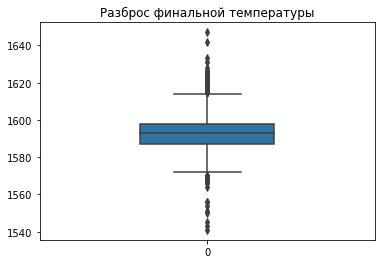

In [73]:
# boxplot for target
sns.boxplot(data=df_train.temp_last, width=0.4)
plt.title('Разброс финальной температуры')
plt.show()

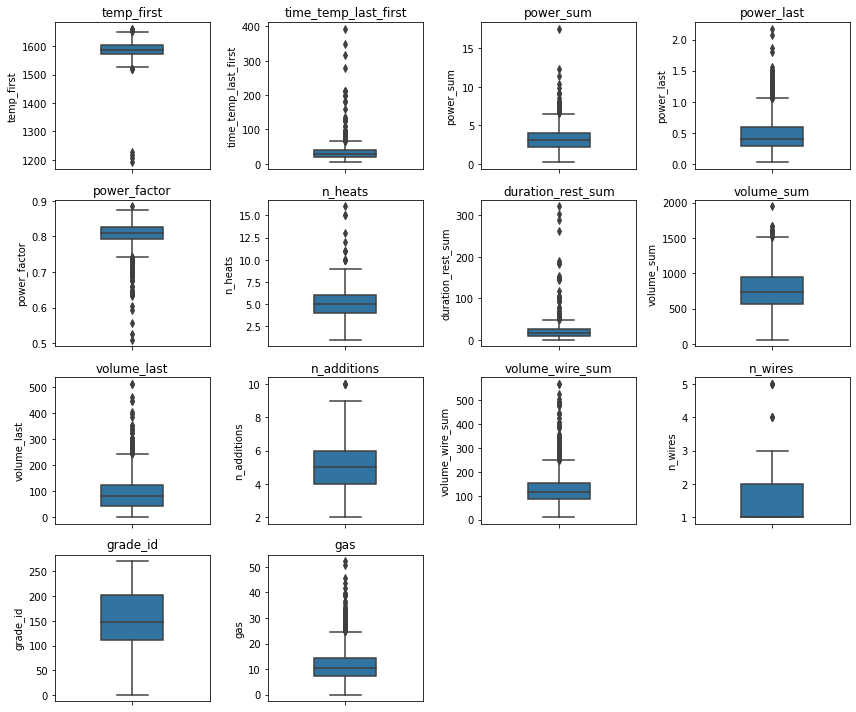

In [74]:
# boxplots for features
plt.figure(figsize=(12,10))

for i,col in enumerate(features):    
    plt.subplot(4, 4, i+1)
    sns.boxplot(y=col, data=df_train, width=0.4)
    plt.title(col)
    
plt.tight_layout()
plt.show()

Видно, что почти во всех данных, включая целевую переменную есть выбросы, некоторые достаточно выраженные. Например - температура около 1200 для начальной температуры, длительность процесса обработки более 300 минут, суммарная активная мощность более 13, коэффициенты мощности менее 0.6, длительность периода без нагрева более 200 минут. Посмотрим на распределение данных при учете выбросов.

In [75]:
# K-Nearest Neighbor for outlier detection
model_knn = KNN()
estimator_knn = model_knn.fit_predict(df_train)

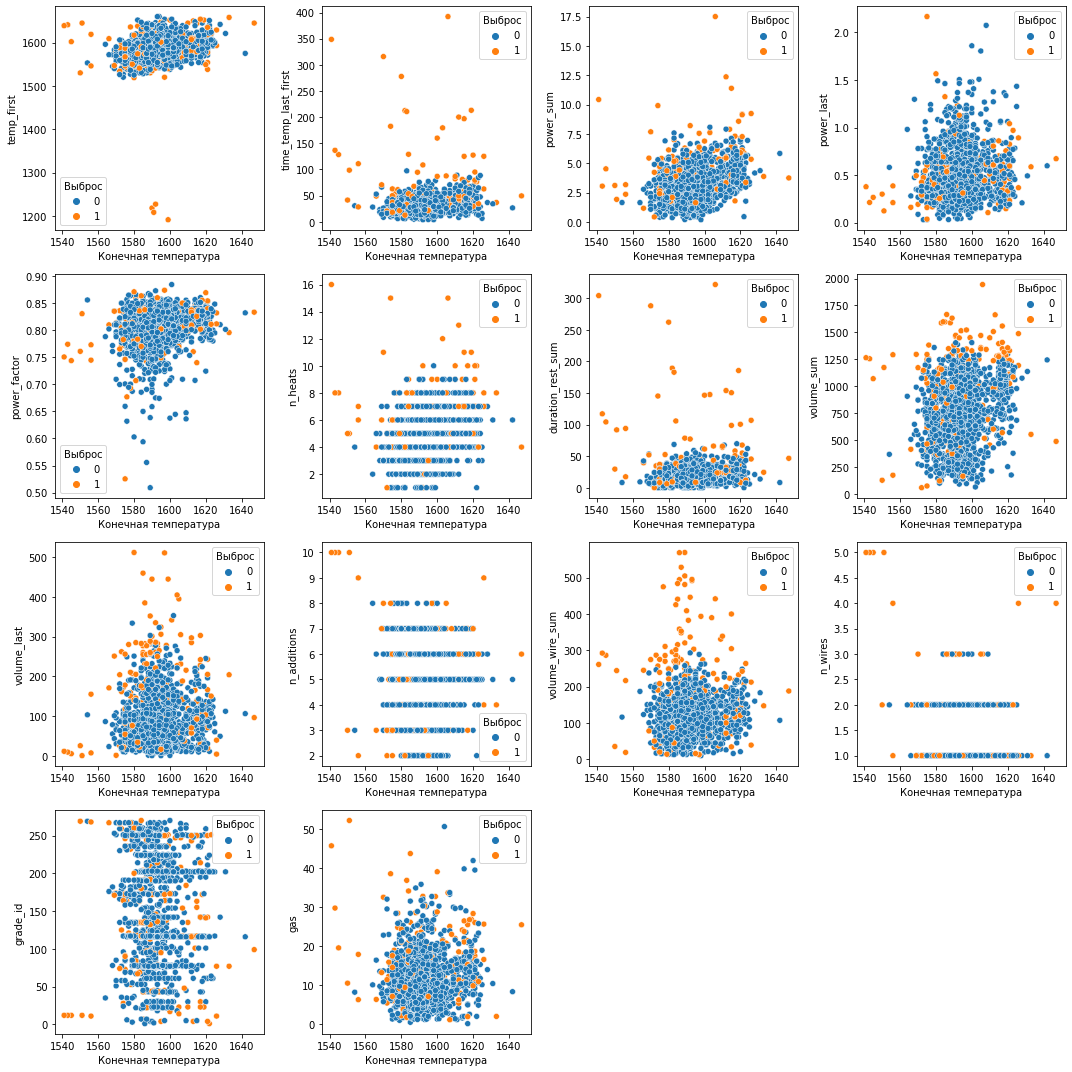

In [76]:
# scatterplots: feature(last temperature)
plt.figure(figsize=(15,15))

for i,col in enumerate(features):    
    plt.subplot(4, 4, i+1)
    sns.scatterplot('temp_last', col, data=df_train, hue=estimator_knn)
    plt.xlabel('Конечная температура')
    plt.legend(title='Выброс')
    
plt.tight_layout()
plt.show()

Поскольку мы не знаем природу этих выбросов (единицы измерения, нормы для этого производства), на это можно обратить внимание заказчика, примем решение не удалять и не изменять выбросы, они могут быть естественными и особенностью данных.

#### Анализ корреляции и взаимодействия признаков с целевым

Исходя из предыдущего рисунка зависимости признаков от конечной температуры - явных зависимостей не видно. 

Для признаков, связанных с нагревом (нам бы хотелось снизить затраты на нагрев) естественно, что чем выше конечная температура сплава, тем вероятнее будет и выше суммарная активная мощность, также можно сказать, что для высоких значений температуры коэффициент мощности всегда высокий. Низкие значения температуры характерны также для сплавов с наибольшим количеством "проволочных" легирующих добавок, при 1-2 добавках диапазон температуры самый широкий.

Некоторые признаки могут сильно коррелировать друг с другом (мультиколлинеарность), что осложнит интерпретируемость модели. Посмотрим на коэффициенты корреляции между признаками. 

In [77]:
# Phik correlation coefficients matrix
phik_overview = df_train.phik_matrix()

interval columns not set, guessing: ['temp_last', 'temp_first', 'time_temp_last_first', 'power_sum', 'power_last', 'power_factor', 'n_heats', 'duration_rest_sum', 'volume_sum', 'volume_last', 'n_additions', 'volume_wire_sum', 'n_wires', 'grade_id', 'gas']


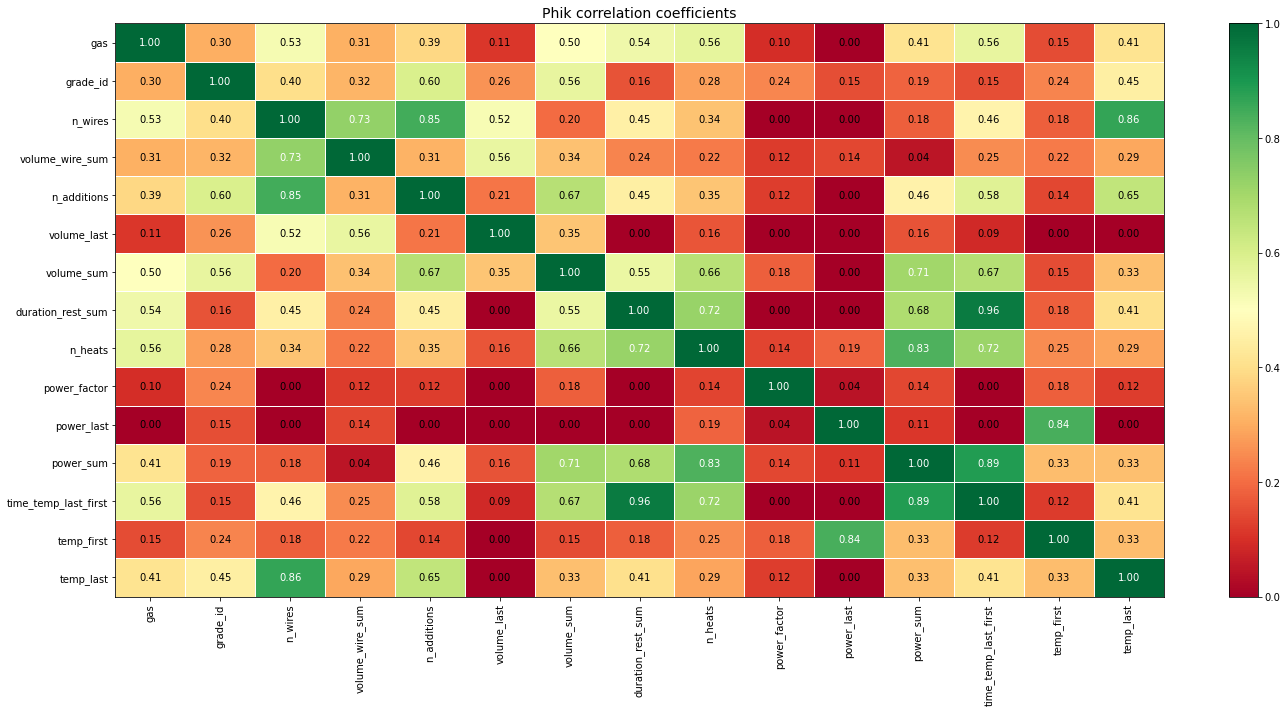

In [78]:
# Plot Phik correlation coefficients matrix
plot_correlation_matrix(phik_overview.values, 
                        x_labels=('temp_last', 'temp_first', 'time_temp_last_first', 
                                  'power_sum', 'power_last', 'power_factor', 'n_heats', 'duration_rest_sum', 
                                  'volume_sum', 'volume_last', 'n_additions', 'volume_wire_sum', 'n_wires', 
                                  'grade_id', 'gas'),
                        y_labels=('temp_last', 'temp_first', 'time_temp_last_first', 
                                  'power_sum', 'power_last', 'power_factor', 'n_heats', 'duration_rest_sum', 
                                  'volume_sum', 'volume_last', 'n_additions', 'volume_wire_sum', 'n_wires', 
                                  'grade_id', 'gas'), 
                        title="Phik correlation coefficients", 
                        figsize=(20, 10),
                        vmin=0, vmax=1)

Видно, что сильно с целевым признаком коррелируют количество "проволочных" добавок и, чуть меньше, количество введений добавок. Умеренная корреляция наблюдается с количеством газа, маркой стали, суммарным объемом, длительностью периода без нагрева, суммарной активной мощностью, первоначальной температурой.

Однако циклов нагрева и суммарный объем добавок сильно коррелируют с некоторыми другими признаками, примем решение удалить эти параметры. Удалим также объем последней добавки и активную мощность последнего нагрева, у них нулевая корреляция с конечной температурой.

In [79]:
# drop some features
df_train = df_train.drop(['n_heats', 'volume_sum', 'volume_last', 'power_last'], axis=1)
df_test = df_test.drop(['n_heats', 'volume_sum', 'volume_last', 'power_last'], axis=1)
list(df_train) == list(df_test)

True

**Вывод**: Из 7 датасетов с данными из различных источников был составлен один, который включает 2329 разных партий стали. В качестве признаков были выбраны:
- первый замер температуры - начальная температура сплава, до введения легирующих добавок, имеет умеренную корреляцию с целевым признаком, также, как правило, чем она выше, тем выше и конечная температура
- длительность обработки - время в минутах между первым и последним замерами, для высоких конечных температур оно не больше часа
- суммарная активная мощность, умеренно коррелирует с конечной температурой, чем выше финальная температура - тем выше мощность
- медианное значение коэффициента мощности, всегда высокий для высоких значений финальной температуры
- суммарная длительность без нагрева в минутах, умеренно коррелирует с финальной температурой
- количество легирующих добавок, заметно коррелирует с финальной температурой
- суммарный объем легирующих добавок в виде проволоки, скорее слабо коррелирует с финальной температурой
- количество легирующих добавок в виде проволоки, высоко коррелирует с целевым признаком
- "марка" стали, отражающая разные сочетания легирующих добавок, умеренно коррелирует с целевым признаком
- объем газа, умеренно коррелирует с финальной температурой

## Исследование моделей

**Выделение целевой переменной**

In [80]:
# target and features
X_train, X_test = df_train.drop('temp_last', axis=1), df_test.drop('temp_last', axis=1)
y_train, y_test = df_train['temp_last'], df_test['temp_last']

**Модели**<br>
Для задачи данного проекта протестируем 3 модели - линейную регрессию с регуляризацией, градиентные бустинги LightGBM и  CatBOOST с разными гипермараметрами. Признаки для моделей отмасштабируем.<br>
Качество моделей оценим по метрике MAE. 
Для масштабирования и для выбора модели регрессии используем pipeline.

In [82]:
# Create the pipeline
pipeline = Pipeline([('scaler', StandardScaler()),
                     ('regr', DummyRegressor())])

In [83]:
# Set grid search params
params = [
    {'regr': [ElasticNet(random_state=RANDOM_STATE)],
     'regr__l1_ratio': [0, 0.5, 1]},
    
    {'regr': [LGBMRegressor(random_state=RANDOM_STATE)],
     'regr__n_estimators': range(20, 200, 10),
     'regr__max_depth': range(4, 12),
     'regr__num_leaves': range(35, 150),
     'regr__learning_rate': [0.01, 0.1, 0.3]}, 
       
    {'regr': [CatBoostRegressor(random_state=RANDOM_STATE)],
     'regr__n_estimators': range(20, 200),
     'regr__depth': [4, 6, 8, 10],
     'regr__learning_rate': [0.01, 0.1, 0.3],
     'regr__l2_leaf_reg': [0.2, 0.5, 1, 3]}]

In [84]:
# Construct grid search
grid = RandomizedSearchCV(pipeline,
                          params,
                          cv=3,
                          verbose=False,
                          scoring='neg_mean_absolute_error',
                          n_jobs=-1,
                          random_state=RANDOM_STATE)

In [94]:
# Fit the grid search object
grid.fit(X_train, y_train)

0:	learn: 11.1885081	total: 152ms	remaining: 20s
1:	learn: 10.9754275	total: 167ms	remaining: 10.8s
2:	learn: 10.7733292	total: 175ms	remaining: 7.54s
3:	learn: 10.5937221	total: 182ms	remaining: 5.83s
4:	learn: 10.4039867	total: 189ms	remaining: 4.81s
5:	learn: 10.2704474	total: 196ms	remaining: 4.11s
6:	learn: 10.1198722	total: 203ms	remaining: 3.63s
7:	learn: 9.9911581	total: 210ms	remaining: 3.25s
8:	learn: 9.8679213	total: 217ms	remaining: 2.96s
9:	learn: 9.7528039	total: 224ms	remaining: 2.73s
10:	learn: 9.6428352	total: 230ms	remaining: 2.53s
11:	learn: 9.5454226	total: 236ms	remaining: 2.36s
12:	learn: 9.4665279	total: 242ms	remaining: 2.22s
13:	learn: 9.3768161	total: 249ms	remaining: 2.1s
14:	learn: 9.2929004	total: 255ms	remaining: 1.99s
15:	learn: 9.2159244	total: 261ms	remaining: 1.89s
16:	learn: 9.1406162	total: 267ms	remaining: 1.81s
17:	learn: 9.0612646	total: 274ms	remaining: 1.73s
18:	learn: 8.9915449	total: 279ms	remaining: 1.66s
19:	learn: 8.9059806	total: 287ms	rem

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('regr', DummyRegressor())]),
                   n_jobs=-1,
                   param_distributions=[{'regr': [ElasticNet(random_state=270323)],
                                         'regr__l1_ratio': [0, 0.5, 1]},
                                        {'regr': [LGBMRegressor(max_depth=5,
                                                                n_estimators=110,
                                                                num_leaves=62,
                                                                random_state=270323)],
                                         'regr__learning_rate': [0.01, 0.1,
                                                                 0.3],
                                         'regr__max_depth':...(4, 12),
                                         'regr__n_estimators': range(20, 200, 10),
                                         'regr__num_leaves': range(35, 150)},
                                        {'regr': [<catboost.core.CatBoostRegressor object at 0x0000019D22038AF0>],
                                         'regr__depth': [4, 6, 8, 10],
                                         'regr__l2_leaf_reg': [0.2, 0.5, 1, 3],
                                         'regr__learning_rate': [0.01, 0.1,
                                                                 0.3],
                                         'regr__n_estimators': range(20, 200)}],
                   random_state=270323, scoring='neg_mean_absolute_error',
                   verbose=False)

In [95]:
# Mean absolute error
print('MAE:', round(abs(grid.best_score_), 4))

# Training time
time_fit = grid.cv_results_['mean_fit_time'][grid.best_index_]
print(f'Время обучения: {time_fit:.4f} s')

# Prediction time
time_pred = grid.cv_results_['mean_score_time'][grid.best_index_]
print(f'Время  предсказания: {time_pred:.4f} s')

MAE: 5.7211
Время обучения: 4.9792 s
Время  предсказания: 0.0330 s


In [96]:
# Hyperparameters of the best model
print('Гиперпараметры лучшей модели:')
grid.best_params_

Гиперпараметры лучшей модели:


{'regr__n_estimators': 132,
 'regr__learning_rate': 0.1,
 'regr__l2_leaf_reg': 3,
 'regr__depth': 4,
 'regr': <catboost.core.CatBoostRegressor at 0x19d22038af0>}

Посмотрим, какие признаки были для модели важными при принятии решения.

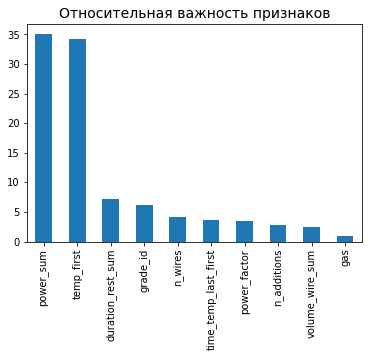

In [97]:
# Importance of the features for RandomForest
feature_importances = pd.DataFrame(
    {'features': list(X_train),
     'feature_importance': grid.best_estimator_.named_steps['regr'].feature_importances_})

# plot feature importances
feature_importances.sort_values(by='feature_importance', ascending=False).plot(kind='bar', x='features', legend=None)
plt.title('Относительная важность признаков', fontsize=14)
plt.xlabel('')
plt.show()

In [98]:
# make table for the report
f_names = ['Суммарная активная мощность', 'Начальная температура', 'Время без нагрева, мин', 
            '"Марка" стали', 'Количество "проволочных" добавок', 'Длительность обработки', 
            'Коэффициент мощности', 'Количество добавок', 'Объем "проволочных" добавок', 'Объем газа']

f_importances = feature_importances['feature_importance'].sort_values(ascending=False)

tbl= pd.DataFrame({'Признаки': f_names, 'Важность для модели, %': round(f_importances)})

**Вывод:** По метрике качества MAE лучшей моделью стал CatBoostRegressor из 132 деревьев максимальной глубиной 4 и при скорости обучения 0.1. Такая модель предсказывает конечную температуру с ошибкой в 5.72 на обучающей выборке и достаточно быстро обучается. Наибольшую важность для модели имели суммарная активная мощность и изначальная температура. В 5 раз меньшую важность - длительность периода без нагрева и "марка" стали, количество газа для продувки имело наименьшее влияние.

Протестируем данную модель на тестовой выборке.

## Тестирование

In [99]:
# Evaluate the model
y_pred = grid.predict(X_test)
print(f'Тестовая выборка MAE = {mean_absolute_error(y_test, y_pred):.2f}')

Тестовая выборка MAE = 5.23


Уровень требуемого качества, оцениваемый по метрике MAE, достигнут - на тестовой выборке он составил 5.2. Меньшая ошибка на тестовой выборке, вероятно может быть объяснена разбивкой данных - мы видели, что в данные есть единичные выбросы, вероятно, в тестовую выборку они не попали.

Сравним это качество с константной моделью.

In [100]:
# Create the dummy model
dummy_regr = DummyRegressor(strategy="mean")
# Fit the model on the training data
dummy_regr.fit(X_train, y_train)

# Make predictions on the test data
pred_dummy = dummy_regr.predict(X_test)

# Evaluate the model
MAE_dummy = mean_absolute_error(y_test, pred_dummy)

print('MAE константной модели:', round(MAE_dummy, 4))

MAE константной модели: 7.4885


Посмотрим также, как предсказания модели сочетаются с реальными значениями.

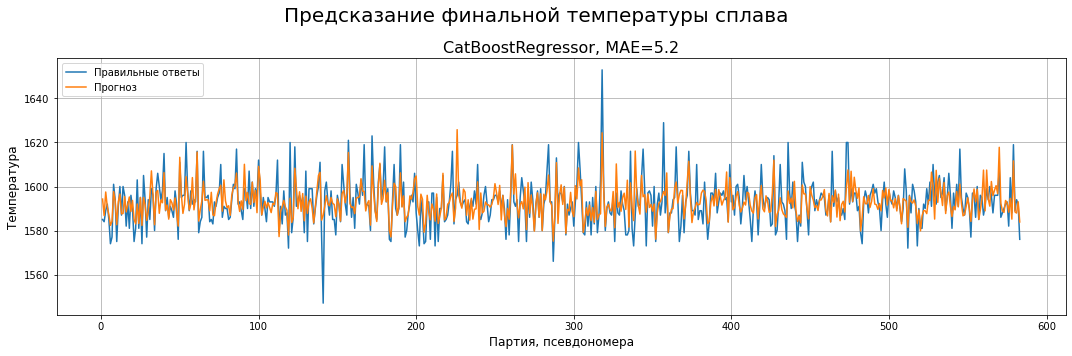

In [102]:
# plot test and predicted data
plt.figure(figsize=(15, 5))
plt.plot(range(1, len(y_test)+1), y_test)
plt.plot(range(1, len(y_test)+1), y_pred)
plt.suptitle('Предсказание финальной температуры сплава', fontsize=20)
plt.title('CatBoostRegressor, MAE=5.2', fontsize=16)
plt.ylabel('Температура', fontsize=12)
plt.xlabel('Партия, псевдономера', fontsize=12)
plt.legend(['Правильные ответы', 'Прогноз'], 
           loc='upper left')
plt.tight_layout()
plt.grid()
plt.show()

**Вывод**: были исследованы три модели для решения задачи регрессии - предсказания финальной температуры сплава. Лучшее качество, оцененное по MAE на кросс-валидации, показал CatBoostRegressor. 
На тестовой выборке данная модель ошибается на 5.2, тогда как константная модель (предсказание всегда среднего) имеет ошибку 7.5.<br>
Наибольшую важность для модели имели следующие признаки - суммарная активная мощность и изначальная температура. Оказывалт влияние, но значительно меньше - длительность периода без нагрева и "марка" стали. Можно указать заказчику, что изменение этих параметров будет отражаться на изменении конечной температуры.<br>
Кажется, что модель предсказывает чуть лучше высокие температуры сплавов, хотя и занижает их, а вот температуры ниже средних (1580) как правило предсказывает с ошибкой. Это может быть следствием небольшого количества данных с близкими к крайним значениями финальной температуры, возможно, "низких" температур чуть меньше.

Можно заключить, что разработанная модель хорошо предсказывает конечную температуру сплава. 

## Отчет

В настоящем проекте решалась задача предсказания температуры стали по окончанию процесса обработки. Предсказание финальной температуры может помочь оптимизировать производственные расходы на металлургическом комбинате.<br> 
Для решения этой задачи было необходимо разработать модель машинного обучения, используя исторические данные о процессе обработки разных партий стали за определенный период. В качестве данных было предоставлено (для каждой партии):
- время измерения и значения температуры стали
- время включения и выключения нагрева сплава, мощность и реактивная мощность каждого нагрева
- время добавления и тип легирующих добавок
- данные о продуве сплава газом

Можно предположить, что, зная конечную температуру, можно оптимизировать процесс обработки, в первую очередь, уменьшив количество/длительность циклов нагрева сплава как самого энергоемкого процесса, а также скорректировать введение легирующих добавок и продувку газом.

**Данные** были предоставлены за 4 месяца - с мая по август 2019г. Предварительный анализ данных выявил некоторые особенности и проблемы:
- примерно для 20% партий отсутвовало значение замера финальной температуры, такие партии были исключены. Кроме того, были исключены партии, где была единственная запись времени замера и температуры. Стоит заметить, что данные отсутвовали подряд для всех последних партий - почти для всего августа. Это похоже на технологическую ошибку, вероятно заказчику стоит исследовать ее причины. 
- не для всех партий с известной конечной температурой известны остальные показатели: в соответсвии с пожеланием заказчика принимаем в рассчет только те партии, где есть оба типа легирующих добавок, продувка газом и наличие циклов нагрева.
- значения финальной температуры всегда были выше 1540, а в большинстве случаев не меньше 1580. Если производится только сталь различных марок (диапазон температур плавления примерно [1450-1520](https://ru.wikipedia.org/wiki/%D0%A1%D1%82%D0%B0%D0%BB%D1%8C#%D0%A5%D0%B0%D1%80%D0%B0%D0%BA%D1%82%D0%B5%D1%80%D0%B8%D1%81%D1%82%D0%B8%D0%BA%D0%B8_%D1%81%D1%82%D0%B0%D0%BB%D0%B8) градусов), все наши партии "перегреты", а значит было затрачено больше мощности на нагрев, чем это необходимо. С другой стороны, эти высокие финальные температуры могут быть "нормальными", мы точно не знаем, какие марки и типы сплавов производятся (возможно это тугоплавкие с вольфрамом). 
- единичные значения начальной температуры сплава ниже 1450 градусов. Это также может быть как аномалиями, так и объясняться производством других сплавов с другими температурами плавления (возможно на комбинате производят чугун).
- реактивная мощность циклов нагрева сплавов не постоянна и иногда достигает больших значений,  иногда более, чем в 1.5 раз превышающих активную мощность. Было обнаружено аномальное большое отрицательное реактивной мощности значение, которое было заменено на 0. На комбинате могут провести анализ, с чем может быть связаны высокая реактивная мощность при нагреве сплава. Снижение ее напрямую повысит эффективность нагрева, а значит, и энергозатраты.<br>

**Ключевыми шагами** при выполнении проекта стали:
1. Анализ данных
2. Генерация признаков
3. Объединение данных в один датасет 
4. Анализ взаимодействия признаков и их влияния на целевой признак
5. Отбор признаков
6. Исследование разных моделей и выбор лучшей
7. Тестирование лучшей модели

Были выполнены все основные пункты заявленного плана, за небольшим исключением: 
- выбросы бало решено не обрабатывать, так как они могут быть естественными
- отбор признаков в пайплайне не производился, признаки были отобраны "вручную", поскольку количество признаков получилось небольшим
- не тестировалась линейная регрессия без регуляризации, так как было видно, что многие признаки коррелируют, а зависимость их с целевым не линейна

В настоящем проекте наибольшую трудность представил "дизайн" необходимых признаков, изучение их взаимодействия и возможного влияния на целевую переменную. Не очень очевидно, как некоторые из них могли влиять на финальную температуру. Визуализация зависимости признаков мжду собой и с целевой переменной помогла выявить некоторые особенности изакономерности. Другой сложностью стало отсутвие знаний по предметной области проекта, отчасти она была решена общением с тимлидом, отчасти благодаря изучению информации в интернете. Более эффективно решить эту сложность можно было бы при общении со специалистом в предметной области.

Итоговый датасет включил данные для 2329 разных партий стали. В качестве признаков были выбраны:

*Температура*
- первый замер температуры - начальная температура сплава, до введения легирующих добавок. Как правило, чем она выше, тем выше и конечная температура. Имеет умеренную корреляцию с финальной температурой.
- длительность обработки - время в минутах между первым и последним замерами температуры, для высоких конечных температур оно не больше часа.  Стоит обратить внимание заказчика, что иногда длительность обработки превышает 3 часа (вплоть до 6.5ч) при среднем в 40 мин.<br> 
Кажется, что финальная температура некоторым образом связана с сочетанием этих признаков: для более высоких начальных температур сплавов и более коротком процессе обработки как правило конечная температура более высокая, чем процесс длиннее - тем она ниже.

*Нагрев*
- суммарная активная мощность (так как она линейно зависела от времени нагрева, предполагаем, что это суммарная "потребленная" мощность), умеренно коррелирующая с конечной температурой. Видна некоторая тенденция - чем выше финальная температура - тем выше мощность.
- значение мощности последнего нагрева, не коррелирует с финальной температурой, не видно взаимосвязи.
- медианное значение коэффициента мощности, рассчитанного как отношение активной мощности к полной,  для высоких значений финальной температуры коэффициент мощности всегда высокий. [Считается](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D0%BC%D0%BE%D1%89%D0%BD%D0%BE%D1%81%D1%82%D0%B8), что коэффициент мощности имеет хорошее или высокое значение если он превышает 0.9. Стоит обратить внимание заказчика, что в имеющихся данных он составляет в среднем 0.8, а для многих партий был ниже 0.7, что говорит о преобладании реактивной мощности над активной. Низкий коэффициент мощности характерен только для партий с низкой суммарной потраченной на нагрев актвной мощностью. Вероятно, в целях уменьшения энергозатрат первым шагом может быть снижение реактивной мощности в цепях. 
- количество циклов нагрева, слабо коррелирующее с финальной температурой. Обычно около 4, но в некоторых и до 16.
- суммарная длительность без нагрева в минутах, умеренно коррелирует с финальной температурой. Стоит обратить внимание заказчика, что этот показатель мог достигать более 300 минут на фоне средних 19.

*Легирующие добавки*
- суммарный объем легирующих добавок, умеренно коррелирующий с целевым признаком, сильно варьирует.
- объем последней добавки, не коррелирует с финальной температурой.
- количество добавок, заметно коррелирующее с финальной температурой, обычно не превышающее 6.
- суммарный объем легирующих добавок в виде проволоки, скорее слабо коррелирующий с финальной температурой.
- количество легирующих добавок в виде проволоки, сильно коррелирующее с финальной температурой, обычно не превышающее 2.
- "марка" стали - уникальный номер, отражающий разное сочетание легирующих добавок. Умеренно коррелирует с целевым признаком. Всего 270 разных марок, но производятся, в основном, 3-4, а есть и уникальные, которых было произведено всего по одной партии.

*Объем газа*, умеренно коррелирующий с финальной температурой.<br>

Из этих 14 признаков были удалены <u>объем последней добавки</u> и <u>суммарная мощность последнего цикла нагрева</u> как имеющие нулевую корреляцию с целевым признаком, а также <u>количество циклов нагрева</u> и <u>суммарный объем</u> как сильно коррелирующие с некоторыми другими признаками.

**Особенности данных**. Оценка диаграмм размаха и использование метода ближайших соседей показало, что во всех данных, включая целевую переменную имеются выбросы. Некоторые достаточно выраженные, например, начальная температура около 1200, длительность процесса обработки более 300 минут, коэффициенты мощности менее 0.7 (что означает, что реактивная мощность превышала активную). Поскольку природа этих выбросов неизвестна (единицы измерения, нормы для этого производства), было принято решение их не удалять и не изменять. Стоит обратить внимание заказчика на эти данные.

**Разработка и тестирование моделей**
Для задачи данного проекта было протестировано 3 модели - линейная регрессия с регуляризацией, градиентные бустинги LightGBM и CatBOOST с разными гипермараметрами. Перед подачей в модель признаки были отмасштабированы. 
Лучшее качество, оцененное по метрике MAE, показал градиентнай бустинг **CatBoostRegressor**:<br>
MAE обучение: 5.72<br>
MAE тест: 5.23<br>
Время обучения: 4.8 сек<br>
Гиперпараметры:<br>
- random_state = 270323
- n_estimators = 132
- learning_rate = 0.1
- l2_leaf_reg = 3
- depth = 4

Модель показывает намного более высокое качество по сравнению с константной (среднее значение в качестве предсказания). Меньшая ошибка на тестовой выборке, вероятно может быть объяснена разбивкой данных, вероятно, в тестовую выборку попало меньше выбросов.

По важности для модели с большим отрывом победили **суммарная активная мощность** и **изначальная температура**. В 5 раз меньшую важность показала длительность периода без нагрева и "марка" стали, количество газа для продувки имело наименьшее влияние.

In [103]:
# print table with feature importancies
display(tbl)

,Признаки,"Важность для модели, %"
2,Суммарная активная мощность,35.0
0,Начальная температура,34.0
4,"Время без нагрева, мин",7.0
8,"""Марка"" стали",6.0
7,"Количество ""проволочных"" добавок",4.0
1,Длительность обработки,4.0
3,Коэффициент мощности,3.0
5,Количество добавок,3.0
6,"Объем ""проволочных"" добавок",2.0
9,Объем газа,1.0


**Рекомендации по улучшению модели**:

Было видно, что имеются три-четыре основных марки стали и три кластера финальной температуры, в которых наибольшее количество данных имеет температуру около 1600, а два других, 1650 и 1675, небольшие. Возможно увеличение количества редких марок стали и редких начальных и финальных температур может повысить качество модели. Видно, что крайние значения финальной температуры (как самые высокие, так и самые низкие) модель предсказывает хуже.

**Рекомендации заказчику**:
- исследовать наличие высоких значений реактивной мощности в цепях
- исследовать причину серийных пропусков записи финальной температуры сплава
- для оптимизации процесса обратить внимание на суммарную активную мощность, как важный фактор, влияющий на конечную температуру. Исходя из наличия очень долгих процессов обработки, большого количества циклов нагрева, создается впечатление, что процесс нагрева стали может быть оптимизирован (количество циклов, их длительность, длительность периода без нагрева), сокращение времени производства партии позволит производить больше партий, что может увеличить доход комбината
- обратить внимание на начальную температуру сплава, как второй важный фактор, влияющий на предсказание температуры моделью, вероятно, не стоит нагревать сплав, если у него уже высокая температура
- исследовать влияние факторов на финальную температуру в зависимости от основных типов и марок стали
- учитывать то, что процесс обработки имеет обратную связь - несколько измерений температуры и химического состава в процессе, многие параметры, используемые моделью могут меняться в зависимости от этих показателей, что не учитывает модель, вероятно стоит использовать и промежуточные значения температур
- исследовать влияние факторов на потребляемую мощность - она ниже при более высоких начальных температурах, выше при долгих процессах обработки (возможно, можно сократить), большем объеме добавок (вводить более точное количество добавок и лучше контролировать вводимое количество) и газа (возможно можно уменьшить)